# Library

In [1]:
# ===============================
# Librairies
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import math  
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from IPython.display import Image, display

# import yfinance as yf
import ta
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
import shap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import optuna
from functools import partial

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Data import and feature creations

In [2]:
"""
# ===============================
# Download daily OHLCV data
# ===============================
#symbol = "^GSPC"
symbol = "ES=F"
start  = "2010-01-01"
end    = None

df = yf.download(symbol, start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df.head()
"""

'\n# ===============================\n# Download daily OHLCV data\n# ===============================\n#symbol = "^GSPC"\nsymbol = "ES=F"\nstart  = "2010-01-01"\nend    = None\n\ndf = yf.download(symbol, start=start, end=end)\nif isinstance(df.columns, pd.MultiIndex):\n    df.columns = df.columns.get_level_values(0)\ndf.head()\n'

In [3]:
# ===============================
# Load a real time series
# ===============================
def load_data_from_csv(filepath):
    # Load CSV without header
    df = pd.read_csv(filepath, header=None)
    # Combine first two rows into a single header
    header1 = df.iloc[0].fillna("")  # market symbols
    header2 = df.iloc[1].fillna("")  # OHLCV etc
    # Create new column names
    new_header = []
    for h1, h2 in zip(header1, header2):
        if h1 != "":
            new_header.append(f"{h1}_{h2}" if h2 != "" else h1)
        else:
            new_header.append(h2)
    # Drop first two rows from the data
    df = df[2:]
    df.columns = new_header
    df = df.reset_index(drop=True)
    # Optional: remove fully empty columns
    df = df.dropna(axis=1, how='all')
    return df

df_load = load_data_from_csv('../data/Stock_Market_Initial_Data.csv')

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_73630/847830797.py:6: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,64,65,66,67,68,69,71,72,73,74,75,76,78,79,80,81,82,83,85,86,87,88,89,90,92,93,94,95,96,97,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,141,142,143,144,145,146,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,165,166,167,169,170,171,172,173,174,176,177,178,179,180,181,183,184,185,186,187,188,190,191,192,193,194,195,197,198,199,200,201,202,204,205,206,207,208,209,211,212,213,214,215,216,218,219,220,221,222,223,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None)


In [4]:
# ===============================
# Function to extract market data for a specific index from the CSV file
# ===============================
def extract_market_data(df, market_name):
    """
    Extract Date + OHLCV columns for a given market
    """
    df.columns = df.columns.str.strip()
    high_col_candidates = [c for c in df.columns if c.startswith(f"{market_name}_High")]
    if not high_col_candidates:
        raise ValueError(f"Column starting with {market_name}_High not found.")
    
    high_col = high_col_candidates[0]
    high_idx = df.columns.get_loc(high_col)
    
    # Date + next 6 columns (High, Low, Open, Close, Volume, Adj Close)
    cols_idx = [0] + list(range(high_idx, high_idx + 6))
    df_market = df.iloc[:, cols_idx].copy()
    df_market = df_market.reset_index(drop=True)
    
    # Rename columns for clarity
    df_market.columns = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
    df_market[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']] = df_market[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].astype(float)
    return df_market

# Example for ^GSPC
df_gspc = extract_market_data(df_load, '^GSPC')
df_gspc['Date'] = pd.to_datetime(df_gspc['Date'])
df_gspc = df_gspc.set_index('Date')
df_gspc = df_gspc.drop(columns=['Adj Close'])

In [5]:
# ===============================
# Preprocess the data to add additional informations
# ===============================
def add_indicators(df: pd.DataFrame, horizon=5) -> pd.DataFrame:
    df = df.copy()


    # ── Log return target ─────────────────────────────────────
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = df['Log_Return'].shift(-horizon).rolling(horizon).sum()


    # ── Momentum ──────────────────────────────────────────────
    for length in [5, 10, 15]:
        df[f"RSI_{length}"] = ta.momentum.RSIIndicator(close=df["Close"], window=length).rsi()
    df["ROC_10"] = ta.momentum.ROCIndicator(close=df["Close"], window=10).roc()
    df["MOM_4"] = df["Close"] - df["Close"].shift(4)
    df["MOM_10"] = df["Close"] - df["Close"].shift(10)


    # ── Oscillators ───────────────────────────────────────────
    stoch = ta.momentum.StochasticOscillator(high=df["High"], low=df["Low"], close=df["Close"], window=14, smooth_window=3)
    df["Stoch_K"] = stoch.stoch()
    df["Stoch_D"] = stoch.stoch_signal()
    df["CCI_20"] = ta.trend.CCIIndicator(high=df["High"], low=df["Low"], close=df["Close"], window=20).cci()


    # ── Trend ─────────────────────────────────────────────────
    for length in [5, 10, 20, 50]:
        df[f"SMA_{length}"] = ta.trend.SMAIndicator(close=df["Close"], window=length).sma_indicator()
        df[f"EMA_{length}"] = ta.trend.EMAIndicator(close=df["Close"], window=length).ema_indicator()

    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()

    df['VWMA_20'] = ta.volume.VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume'], 20).volume_weighted_average_price()


    # ── Volatility ───────────────────────────────────────────
    bb = ta.volatility.BollingerBands(df['Close'], 20)
    df['BB_Mavg'] = bb.bollinger_mavg()
    df['BB_HBand'] = bb.bollinger_hband()
    df['BB_LBand'] = bb.bollinger_lband()
    df['BB_Width'] = df['BB_HBand'] - df['BB_LBand']

    df['ATR_14'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], 14).average_true_range()
    
    kc = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'], 20)
    df['KC_HBand'] = kc.keltner_channel_hband()
    df['KC_LBand'] = kc.keltner_channel_lband()
    df['KC_Width'] = df['KC_HBand'] - df['KC_LBand']


    # ── Volume ───────────────────────────────────────────────
    df['Volume_Change'] = df['Volume'].pct_change()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['AD'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()
    df['VWAP'] = (df['Close']*df['Volume']).cumsum() / df['Volume'].cumsum()
    df['Volume_SMA_20'] = df['Volume'].rolling(20).mean()


    # ── OHLC ratios ──────────────────────────────────────────
    df['Candle_Body'] = df['Close'] - df['Open']
    df['Upper_Shadow'] = df['High'] - df[['Close','Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close','Open']].min(axis=1) - df['Low']
    df['HL_Ratio'] = df['High'] / df['Low']
    df['CO_Ratio'] = df['Close'] / df['Open']


    # ── Returns ──────────────────────────────────────────────
    df = df.replace([np.inf, -np.inf], np.nan)  # only a volume change issue on the last one for horizon 
    df = df.dropna()
    return df


# Example usage
# only taking the last 5 years ??
lenght = int(df_gspc.shape[0] * 0.3)
df_downsample = df_gspc.iloc[lenght:].copy()
HORIZON = 5
df_ta = add_indicators(df_downsample, horizon=HORIZON)
df_ta.tail()

,High,Low,Open,Close,Volume,Log_Return,Target,RSI_5,RSI_10,RSI_15,ROC_10,MOM_4,MOM_10,Stoch_K,Stoch_D,CCI_20,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,MACD,MACD_Signal,VWMA_20,BB_Mavg,BB_HBand,BB_LBand,BB_Width,ATR_14,KC_HBand,KC_LBand,KC_Width,Volume_Change,OBV,AD,VWAP,Volume_SMA_20,Candle_Body,Upper_Shadow,Lower_Shadow,HL_Ratio,CO_Ratio
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-26,3886.149902,3824.070068,3825.969971,3830.600098,4.817310e+09,-0.007415,-0.018685,68.303994,59.716040,54.771362,7.088844,164.820069,253.570069,85.921426,93.571861,153.604379,3781.116064,3793.083423,3725.165014,3751.122371,3694.641003,3739.872750,3858.999219,3817.478495,-9.503818,-44.111835,3695.388050,3694.641003,3864.220391,3525.061615,339.158776,85.654860,3775.423995,3613.153975,162.270020,-0.005329,1.248262e+12,1.828250e+12,2046.805494,4.609179e+09,4.630127,55.549804,1.899903,1.016234,1.001210
2022-10-27,3859.949951,3803.790039,3834.689941,3807.300049,4.687320e+09,-0.006101,-0.023226,61.228567,56.915809,53.084864,3.743692,54.550049,137.390137,80.016249,88.310108,113.232391,3809.420068,3797.822298,3738.904028,3761.336494,3702.982507,3746.294397,3849.664419,3817.079341,-3.675620,-36.024592,3704.421206,3702.982507,3877.425501,3528.539514,348.885987,83.548078,3783.287488,3623.062488,160.225000,-0.026984,1.243574e+12,1.824148e+12,2047.289684,4.609454e+09,-27.389892,25.260010,3.510010,1.014764,0.992857
2022-10-28,3905.419922,3808.260010,3808.260010,3901.060059,4.459410e+09,0.024328,-0.034027,74.510045,64.383303,58.583218,8.874791,103.719971,317.989991,98.946485,88.294720,138.424365,3839.082080,3832.234885,3770.703027,3786.740779,3718.754504,3761.033984,3842.010815,3820.372702,8.411950,-27.137283,3718.238468,3718.754504,3904.570251,3532.938758,371.631493,84.588920,3796.672481,3635.462496,161.209986,-0.048623,1.248034e+12,1.828207e+12,2047.774611,4.550157e+09,92.800049,4.359863,0.000000,1.025513,1.024368
2022-10-31,3893.729980,3863.179932,3881.850098,3871.979980,4.820620e+09,-0.007482,-0.016977,65.774677,60.754441,56.387173,5.275494,12.869873,194.030029,91.919593,90.294109,124.256277,3854.010059,3845.483250,3790.106030,3802.238815,3728.432007,3771.600270,3834.880815,3822.396517,15.466627,-18.616501,3729.655361,3728.432007,3924.705465,3532.158548,392.546917,81.252578,3804.315308,3649.392334,154.922974,0.081000,1.243213e+12,1.826164e+12,2048.290311,4.550854e+09,-9.870118,11.879882,8.800048,1.007908,0.997457
2022-11-01,3911.790039,3843.800049,3901.790039,3856.100098,4.481210e+09,-0.004110,-0.010820,60.901044,58.745439,55.177018,3.659163,25.500000,136.120118,86.747115,92.537731,107.842743,3853.408057,3849.022199,3803.718042,3812.031776,3731.690515,3779.647872,3829.243013,3823.718226,19.550767,-10.983047,3734.359042,3731.690515,3934.074875,3529.306155,404.768720,80.305250,3809.481482,3654.305505,155.175977,-0.070408,1.238732e+12,1.823304e+12,2048.765268,4.517586e+09,-45.689941,10.000000,12.300049,1.017688,0.988290


In [6]:
df_ta.describe(include='all')

,High,Low,Open,Close,Volume,Log_Return,Target,RSI_5,RSI_10,RSI_15,ROC_10,MOM_4,MOM_10,Stoch_K,Stoch_D,CCI_20,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,MACD,MACD_Signal,VWMA_20,BB_Mavg,BB_HBand,BB_LBand,BB_Width,ATR_14,KC_HBand,KC_LBand,KC_Width,Volume_Change,OBV,AD,VWAP,Volume_SMA_20,Candle_Body,Upper_Shadow,Lower_Shadow,HL_Ratio,CO_Ratio
count,4503.000000,4503.000000,4503.000000,4503.000000,4.503000e+03,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4.503000e+03,4.503000e+03,4503.000000,4.503000e+03,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000
mean,2068.783480,2044.401129,2057.056261,2057.355876,3.771657e+09,0.000259,0.001272,55.630963,54.919911,54.499140,0.315415,2.371244,5.810446,62.895266,62.895426,27.841336,2056.168678,2056.175106,2054.702552,2054.732879,2051.890967,2051.872127,2043.226144,2042.877287,4.038293,4.057785,2050.057309,2051.890967,2116.357644,1987.424291,128.933353,26.263759,2075.630626,2027.134002,48.496624,0.017666,6.597496e+11,8.583662e+11,1401.821233,3.765032e+09,0.299614,4.720234,5.947762,1.012591,1.000231
std,989.602823,978.484700,984.332480,984.323952,1.229622e+09,0.012429,0.024866,19.287640,13.386529,10.806037,3.316243,49.721281,76.310637,31.191649,28.754769,108.421847,983.495357,983.390919,982.567645,982.386892,980.944896,980.486459,975.916508,974.392876,26.076641,24.352761,979.810007,980.944896,1016.805674,947.618004,121.390962,20.370079,992.113220,969.636006,36.757046,0.204398,3.982580e+11,5.925299e+11,242.267725,1.045729e+09,21.757277,6.740813,8.710484,0.010562,0.011000
min,695.270019,666.789978,679.280029,676.530029,7.249400e+08,-0.127652,-0.202607,3.049884,11.391117,17.534880,-25.884597,-496.100097,-732.020019,0.000000,0.866648,-401.396755,690.332007,691.785279,707.927002,713.782198,736.972003,743.372703,788.956798,792.835619,-237.020227,-198.640715,736.010237,736.972003,806.269033,648.975559,19.553685,8.240423,763.642666,710.537505,14.112012,-0.761155,6.591880e+09,-5.051849e+08,1152.775368,1.335125e+09,-150.220214,0.000000,0.000000,1.001457,0.912769
25%,1291.465027,1276.929993,1285.119995,1285.259949,3.070740e+09,-0.004109,-0.008777,41.399661,45.449560,46.599168,-1.040348,-14.949951,-18.270019,36.759805,37.705657,-53.627141,1284.399988,1284.851307,1284.073511,1283.088115,1283.177512,1281.927866,1281.137197,1283.547759,-4.228087,-3.686638,1282.899606,1283.177512,1314.902412,1253.051078,59.652057,13.848558,1298.422015,1269.470336,25.711017,-0.078711,2.350264e+11,2.066628e+11,1203.835247,3.225524e+09,-7.074829,0.689941,0.780029,1.006291,0.996166
50%,1784.829956,1770.449951,1777.479980,1775.500000,3.605150e+09,0.000698,0.003470,57.482896,56.494181,55.694328,0.682071,5.420044,11.780030,71.293809,71.166470,57.258903,1776.561987,1778.018287,1776.249988,1780.344457,1773.073505,1770.838334,1732.410408,1739.438636,7.185721,6.725463,1771.722370,1773.073505,1802.305100,1737.118943,88.464046,18.556936,1785.304168,1759.354169,34.868994,-0.001183,7.318538e+11,8.788737e+11,1318.731529,3.644362e+09,1.059815,2.679932,3.459961,1.009693,1.000576
75%,2695.324951,2661.730102,2682.834961,2681.564941,4.281690e+09,0.005663,0.014201,71.024153,65.084082,62.747361,2.076653,23.029968,37.239930,91.282006,89.135124,110.997308,2681.674048,2680.653324,2682.341992,2686.177966,2681.344763,2683.717228,2683.430195,2691.531872,15.970212,15.487755,2678.255750,2681.344763,2787.682455,2586.415079,147.862182,30.238945,2715.300511,2646.057137,56.462043,0.088964,9.723705e+11,1.394695e+12,1541.173646,4.161605e+09,9.100037,5.979981,7.459961,1.015130,1.005060
max,4818.620117,4780.040039,4804.509766,4796.560059,1.145623e+10,0.109572,0.174887,96.540206,89.023607,86.191530,21.638353,325.150146,426.2

In [7]:
df_ta.isna().sum()

High             0
Low              0
Open             0
Close            0
Volume           0
Log_Return       0
Target           0
RSI_5            0
RSI_10           0
RSI_15           0
ROC_10           0
MOM_4            0
MOM_10           0
Stoch_K          0
Stoch_D          0
CCI_20           0
SMA_5            0
EMA_5            0
SMA_10           0
EMA_10           0
SMA_20           0
EMA_20           0
SMA_50           0
EMA_50           0
MACD             0
MACD_Signal      0
VWMA_20          0
BB_Mavg          0
BB_HBand         0
BB_LBand         0
BB_Width         0
ATR_14           0
KC_HBand         0
KC_LBand         0
KC_Width         0
Volume_Change    0
OBV              0
AD               0
VWAP             0
Volume_SMA_20    0
Candle_Body      0
Upper_Shadow     0
Lower_Shadow     0
HL_Ratio         0
CO_Ratio         0
dtype: int64

In [8]:
# ===============================
# Check stationnarity for the time serie
# ===============================
def check_stationarity(series):  # ADF test
    result = adfuller(series.dropna())  # Drop NaN values if any
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print(" --> The series is stationary")
    else:
        print(" --> The series is not stationary")

print("Testing the stationnarity of the time serie")
check_stationarity(df_ta['Close'])
print()
print("Testing the stationnarity of the log return of the time serie")
check_stationarity(df_ta['Log_Return'])

Testing the stationnarity of the time serie
ADF Statistic: 0.18841228156336598
p-value: 0.9716041337377748
 --> The series is not stationary

Testing the stationnarity of the log return of the time serie
ADF Statistic: -16.21625723870054
p-value: 3.9396830914961814e-29
 --> The series is stationary


# Vizualizations

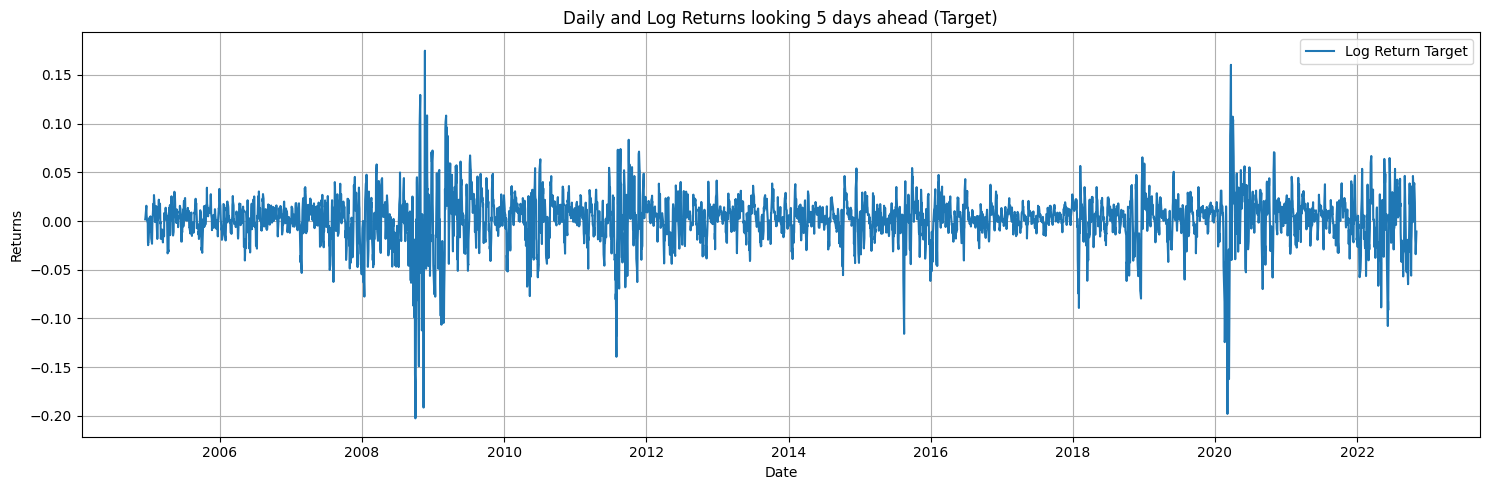

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df_ta['Target'], label='Log Return Target')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title(f"Daily and Log Returns looking 5 days ahead (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

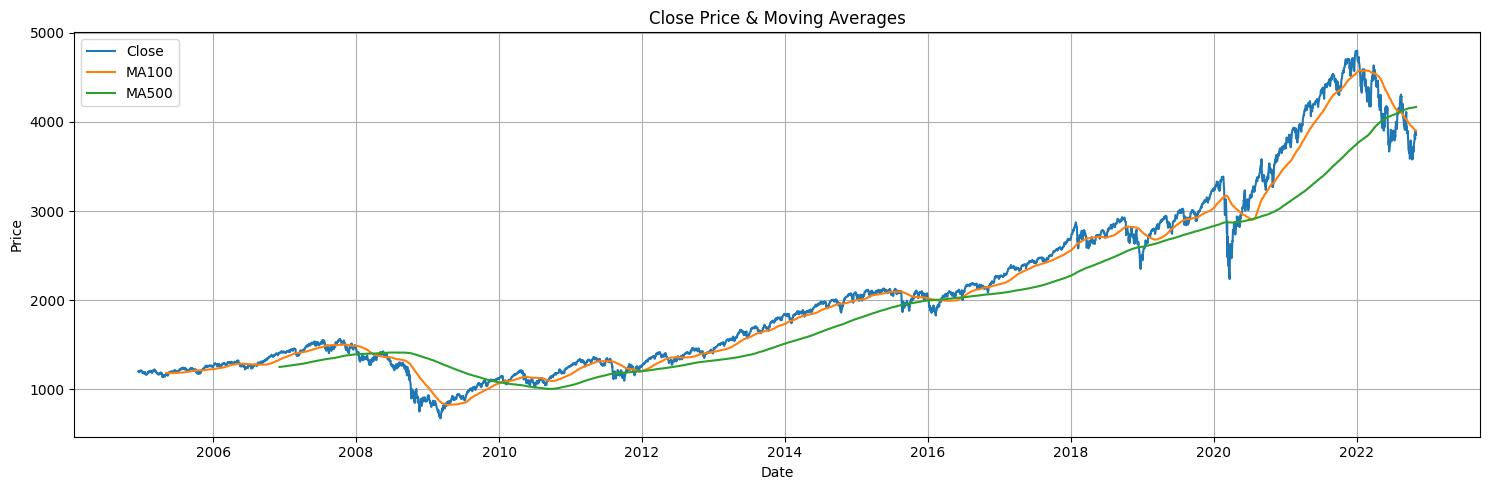

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df_ta['Close'], label='Close')
plt.plot(df_ta['Close'].rolling(window=100).mean(), label='MA100')
plt.plot(df_ta['Close'].rolling(window=500).mean(), label='MA500')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price & Moving Averages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

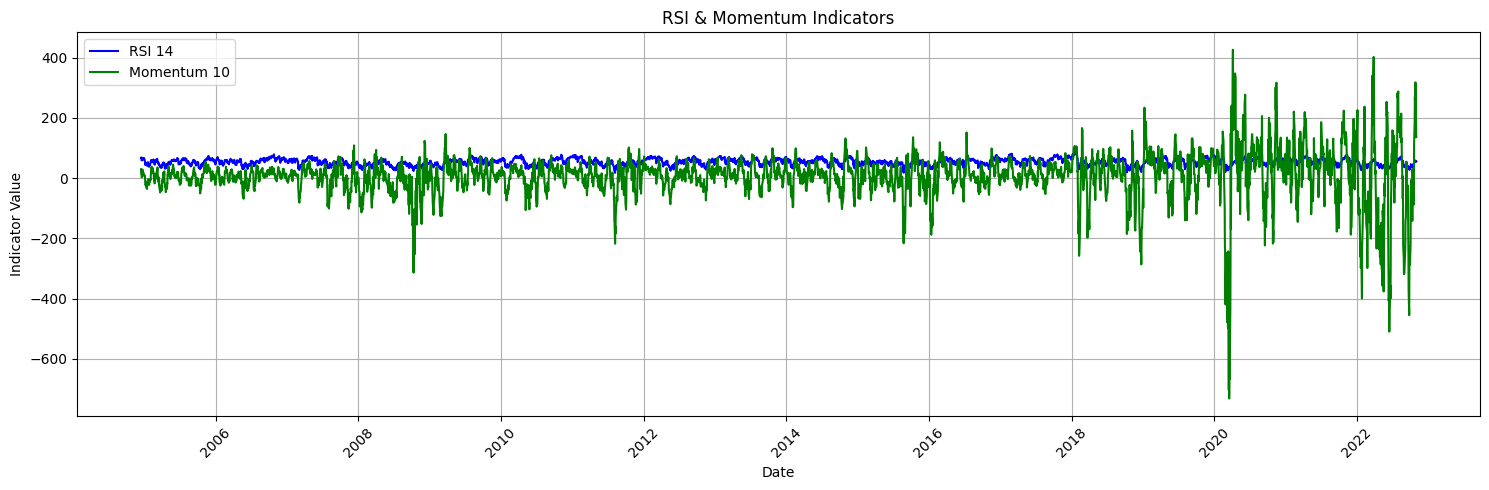

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(df_ta['RSI_15'], label='RSI 14', color='blue')
plt.plot(df_ta['MOM_10'], label='Momentum 10', color='green')
plt.xlabel("Date")
plt.ylabel("Indicator Value")
plt.title("RSI & Momentum Indicators")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


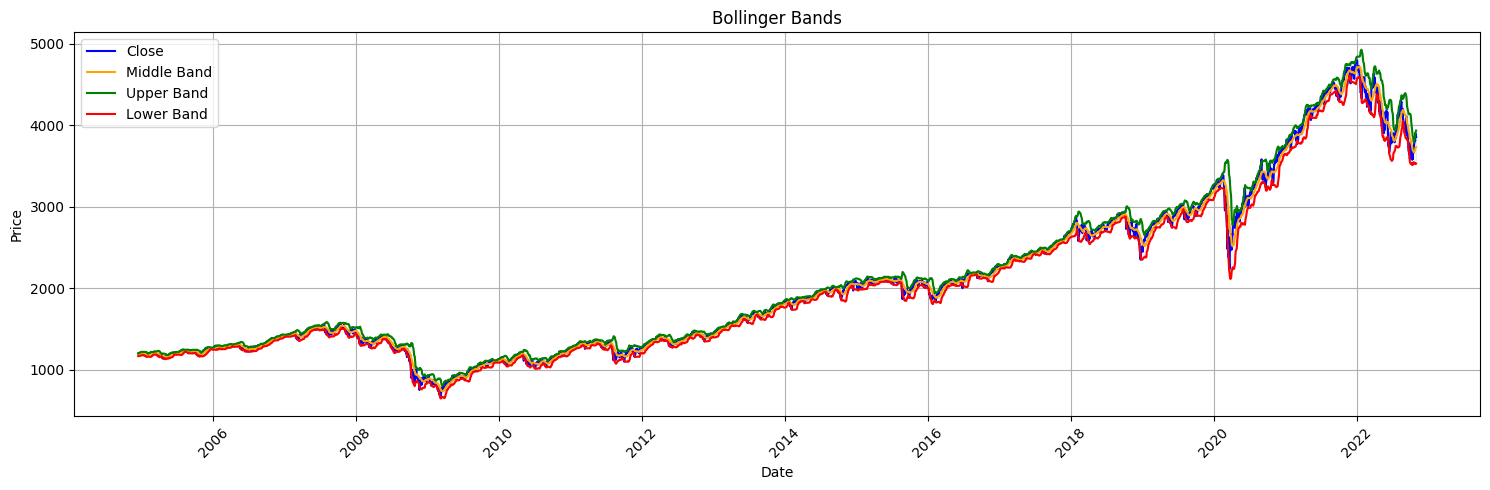

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(df_ta['Close'], label='Close', color='blue')
plt.plot(df_ta['BB_Mavg'], label='Middle Band', color='orange')
plt.plot(df_ta['BB_HBand'], label='Upper Band', color='green')
plt.plot(df_ta['BB_LBand'], label='Lower Band', color='red')
plt.fill_between(df_ta.index, df_ta['BB_LBand'], df_ta['BB_HBand'], color='gray', alpha=0.1)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Bollinger Bands")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

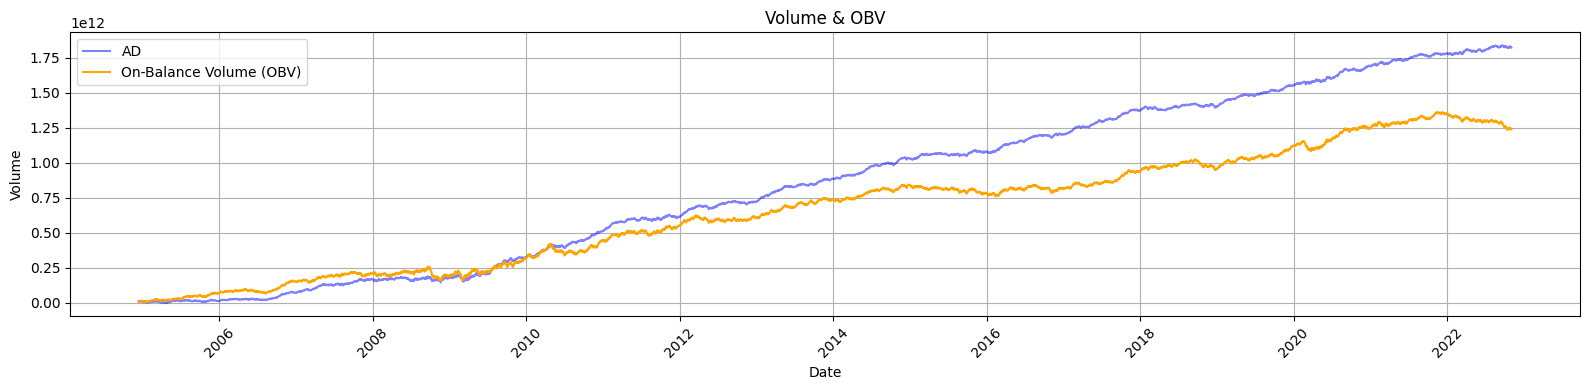

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(df_ta['AD'], label='AD', color='blue', alpha=0.5)
plt.plot(df_ta['OBV'], label='On-Balance Volume (OBV)', color='orange')
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume & OBV")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

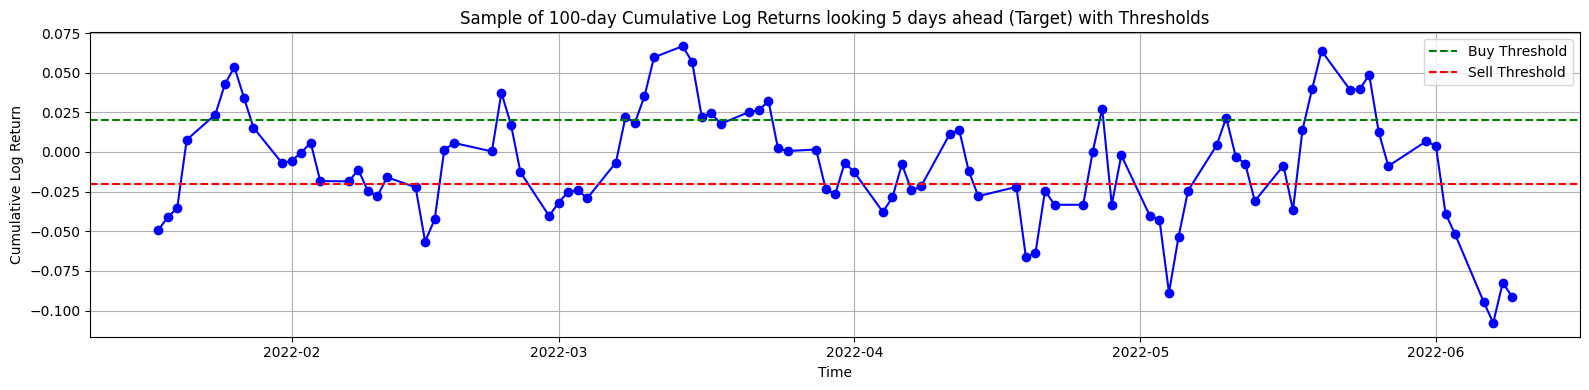

In [14]:
# Take a small sample (e.g. 100 points near the end)
sample = df_ta['Target'].iloc[-200:-100]
plt.figure(figsize=(16,4))
plt.plot(sample.index, sample.values, marker='o', linestyle='-', color='blue')
plt.axhline(0.02, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-0.02, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Sample of 100-day Cumulative Log Returns looking {HORIZON} days ahead (Target) with Thresholds")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_73630/109475618.py:39: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




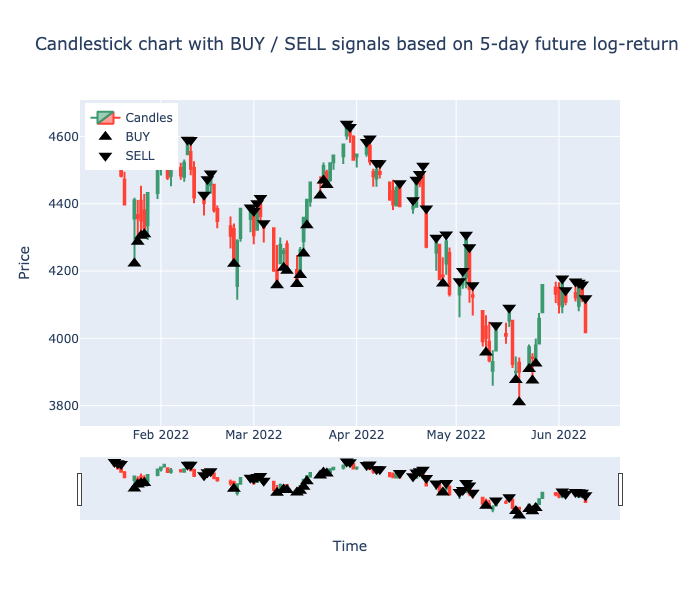

In [15]:
# Take a small sample (e.g. 100 points near the end)
df_slice = df_ta.iloc[-200:-100].copy()
# Identify signals
buy_signals = df_slice[df_slice['Target'] > 0.02]
sell_signals = df_slice[df_slice['Target'] < -0.02]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "improved_lstm_last_test_sample.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

# Data preprocessing

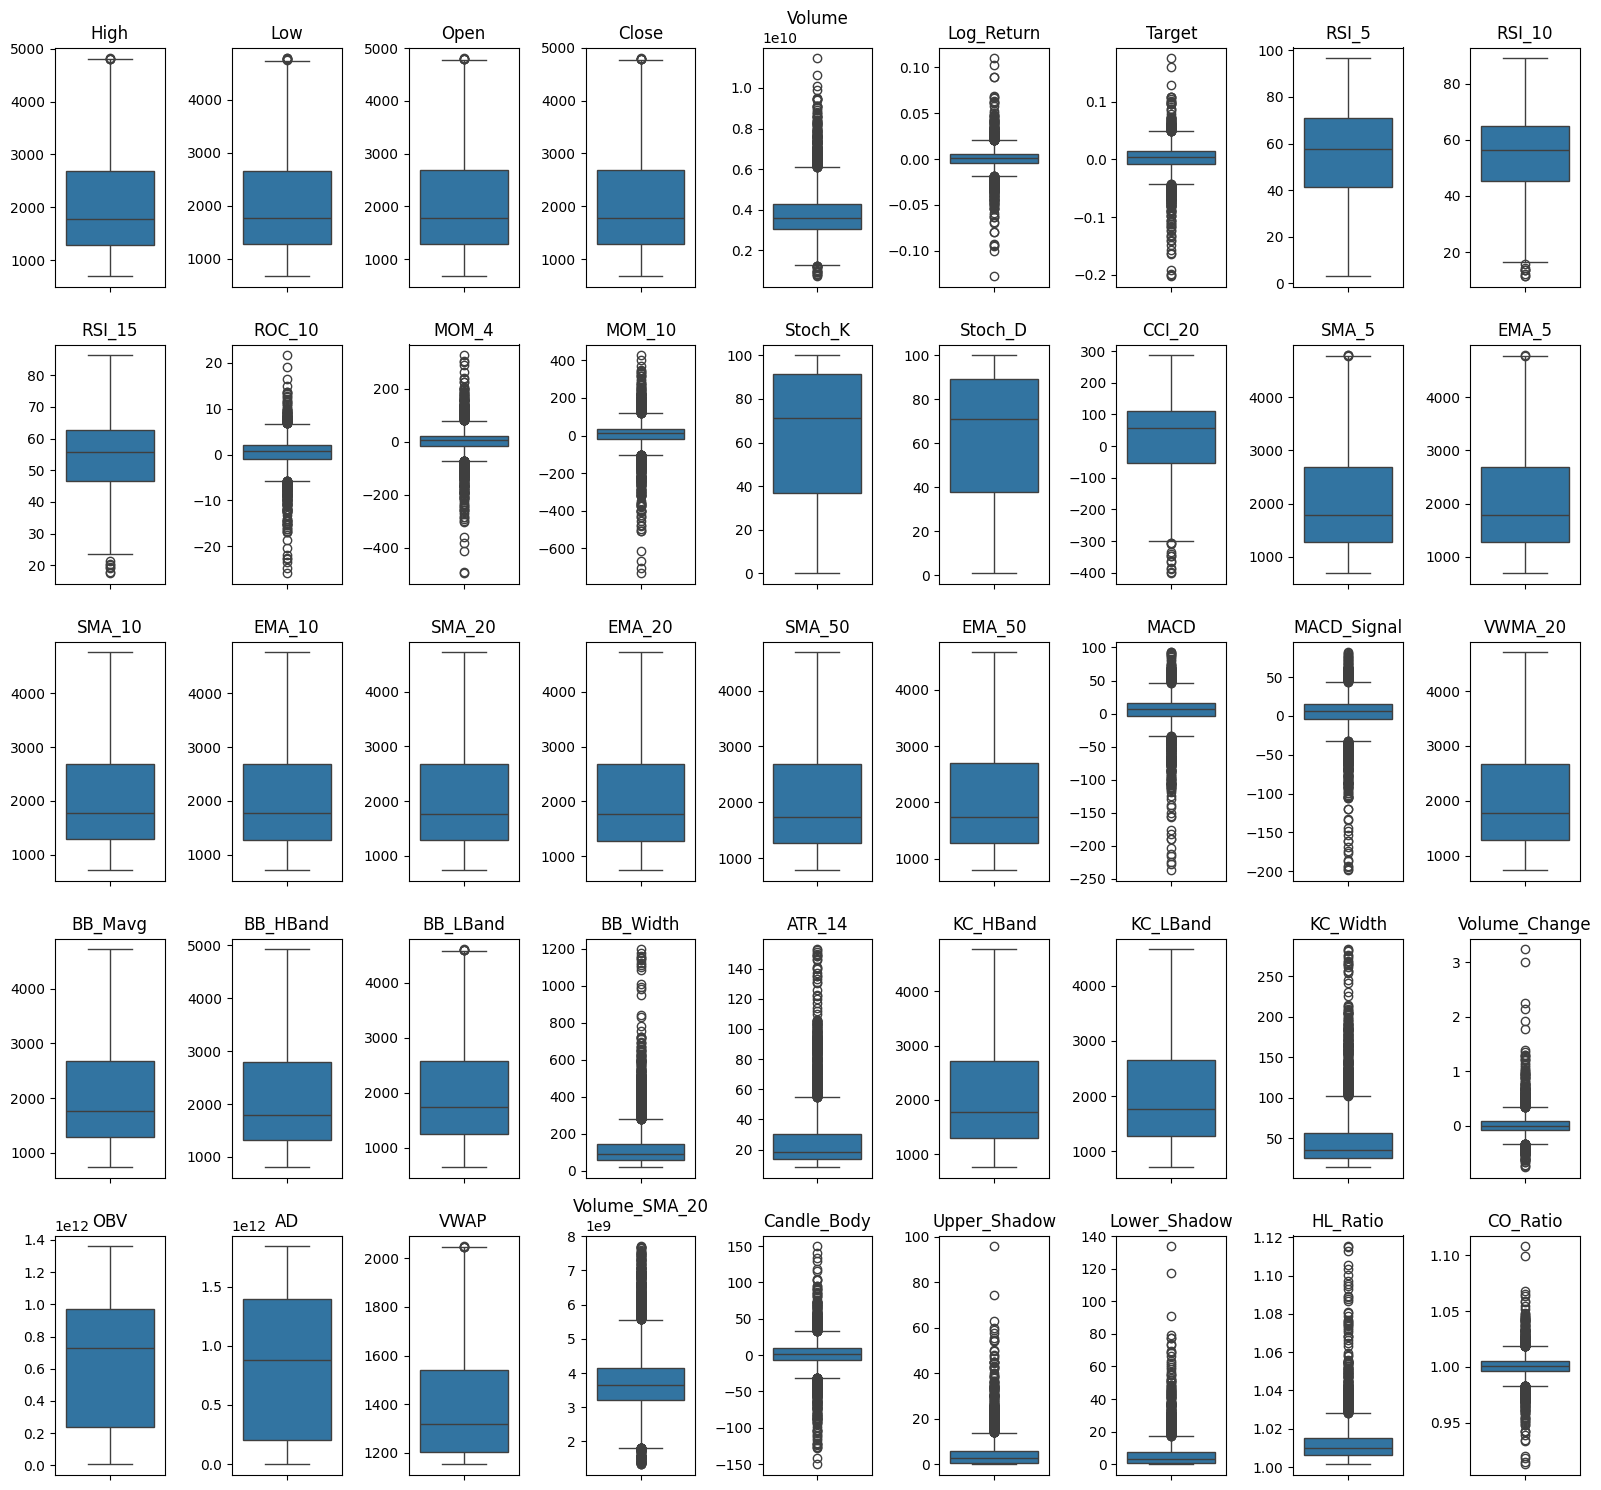

In [16]:
num_cols = 9
num_features = len(df_ta.columns)  
num_rows = math.ceil(num_features / num_cols)  
fig = plt.figure(figsize=(16, num_rows * 3))  
for i, x in enumerate(df_ta.columns, start=1):  
    plt.subplot(num_rows, num_cols, i)  
    ax = sns.boxplot(df_ta[x])  
    ax.set(xlabel=None)  
    plt.title(str(x), loc='center')  
    plt.xlabel(None)  
    plt.ylabel(None)  
plt.tight_layout()  
plt.show()

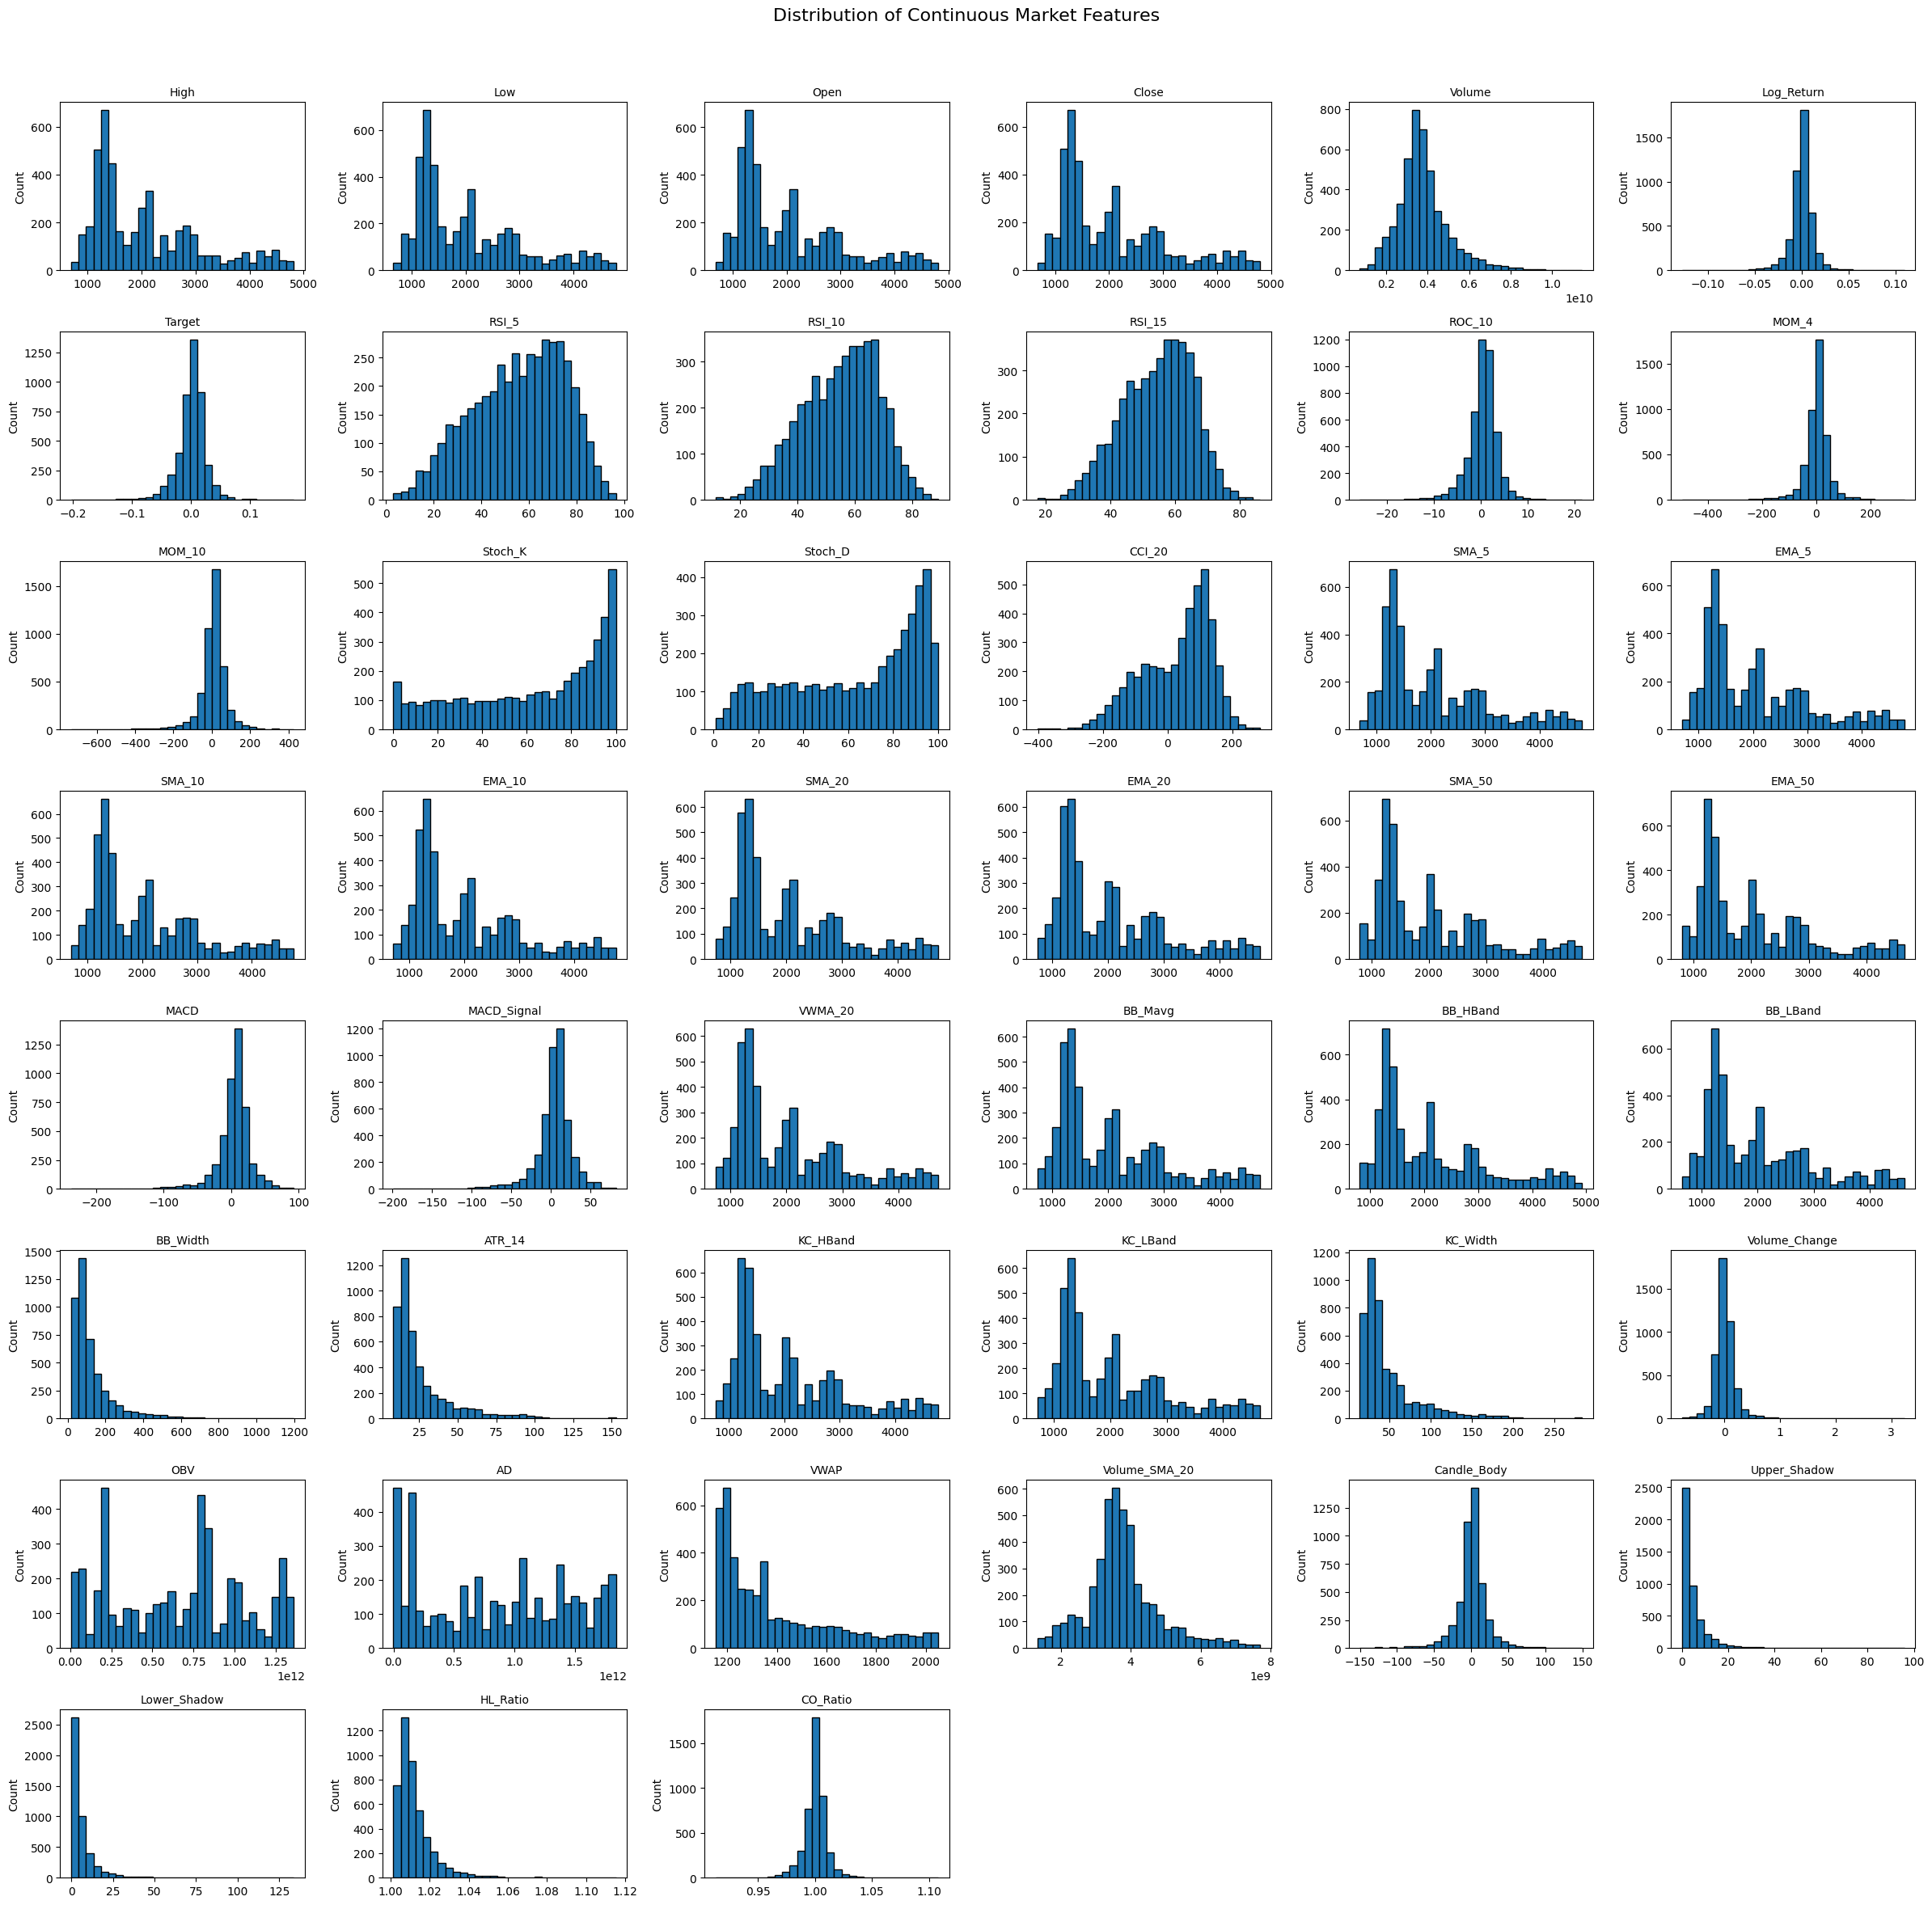

In [17]:
num_cols = 6
num_features = len(df_ta.columns)  
num_rows = math.ceil(num_features / num_cols)  
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 3 * num_rows))
axes = axes.flatten()
for i, col in enumerate(df_ta.columns):
    axes[i].hist(df_ta[col].dropna(),bins=30,edgecolor="black")
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
for j in range(i + 1, len(axes)):  # Remove unused axes
    fig.delaxes(axes[j])
plt.suptitle("Distribution of Continuous Market Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Feature Selection

In [18]:
df_ta.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Log_Return', 'Target',
       'RSI_5', 'RSI_10', 'RSI_15', 'ROC_10', 'MOM_4', 'MOM_10', 'Stoch_K',
       'Stoch_D', 'CCI_20', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20',
       'EMA_20', 'SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'VWMA_20',
       'BB_Mavg', 'BB_HBand', 'BB_LBand', 'BB_Width', 'ATR_14', 'KC_HBand',
       'KC_LBand', 'KC_Width', 'Volume_Change', 'OBV', 'AD', 'VWAP',
       'Volume_SMA_20', 'Candle_Body', 'Upper_Shadow', 'Lower_Shadow',
       'HL_Ratio', 'CO_Ratio'],
      dtype='object')

In [19]:
# ===============================
# Scale the data for pre-analysis
# ===============================
# Use chronological split: 80% train (Walk-Forward for validation), 20% test
split_idx = int(len(df_ta) * 0.8)
train_df = df_ta.iloc[:split_idx].copy()

feature_cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'Log_Return',
                'RSI_5', 'RSI_10', 'RSI_15', 'ROC_10', 'MOM_4', 'MOM_10', 'Stoch_K',
                'Stoch_D', 'CCI_20', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20',
                'EMA_20', 'SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'VWMA_20',
                'BB_Mavg', 'BB_HBand', 'BB_LBand', 'BB_Width', 'ATR_14', 'KC_HBand',
                'KC_LBand', 'KC_Width', 'Volume_Change', 'OBV', 'AD', 'VWAP',
                'Volume_SMA_20', 'Candle_Body', 'Upper_Shadow', 'Lower_Shadow',
                'HL_Ratio', 'CO_Ratio'
            ]
X_scalers = {}
for col in feature_cols:
    scaler = StandardScaler()
    train_df[col] = scaler.fit_transform(train_df[[col]])
    X_scalers[col] = scaler

y_scaler = StandardScaler()
train_df["Target"] = y_scaler.fit_transform(train_df[["Target"]])

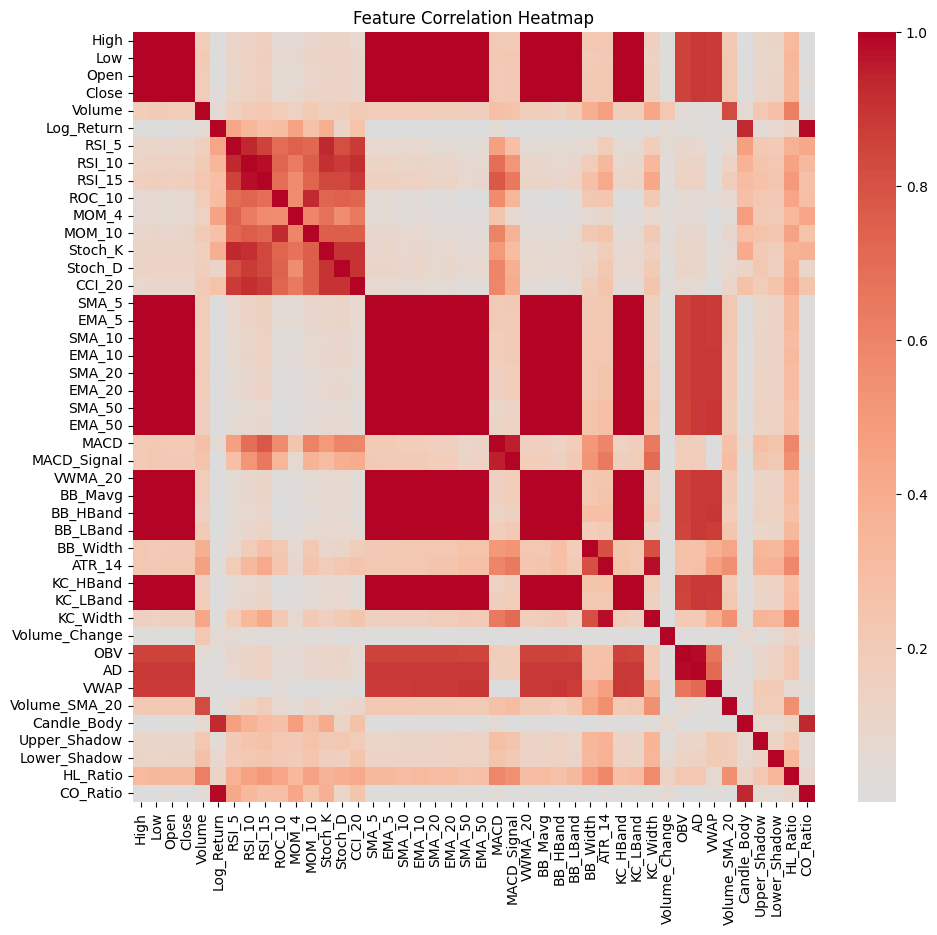

In [20]:
# ===============================
# Correlation Heatmap
# ===============================
plt.figure(figsize=(11, 10))
corr_matrix = train_df[feature_cols].corr().abs()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [21]:
# ===============================
# Highlighting the higly correlated features
# ===============================
threshold = 0.9
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr_value))

print("Highly correlated feature pairs (>|0.9|):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1:11s}  <->  {f2:101s} : {val:.3f}")

Highly correlated feature pairs (>|0.9|):
High         <->  Low                                                                                                   : 1.000
High         <->  Open                                                                                                  : 1.000
High         <->  Close                                                                                                 : 1.000
High         <->  SMA_5                                                                                                 : 1.000
High         <->  EMA_5                                                                                                 : 1.000
High         <->  SMA_10                                                                                                : 0.999
High         <->  EMA_10                                                                                                : 1.000
High         <->  SMA_20                                      

In [22]:
# ===============================
# Looking for the columns to drop
# ===============================
to_drop = set()
for f1, f2, val in high_corr_pairs:
    if f2 not in to_drop:
        to_drop.add(f2)
print("Features to drop due to high correlation:")
print(sorted(to_drop))

feature_cols_reduced = [f for f in feature_cols if f not in to_drop]
print(f"{len(feature_cols)} original features:", )
print("Reduced features :", len(feature_cols_reduced))

Features to drop due to high correlation:
['AD', 'BB_HBand', 'BB_LBand', 'BB_Mavg', 'CCI_20', 'CO_Ratio', 'Candle_Body', 'Close', 'EMA_10', 'EMA_20', 'EMA_5', 'EMA_50', 'KC_HBand', 'KC_LBand', 'KC_Width', 'Low', 'MACD_Signal', 'MOM_10', 'Open', 'RSI_10', 'RSI_15', 'SMA_10', 'SMA_20', 'SMA_5', 'SMA_50', 'Stoch_D', 'Stoch_K', 'VWMA_20']
44 original features:
Reduced features : 16


In [23]:
# ===============================
# Pipeline to select the right indicators
# ===============================
"""
All indicators
   ↓
Variance threshold
   ↓
Correlation clustering
   ↓
Mutual information vs target
   ↓
XGBoost + SHAP
   ↓
Top 10-18 features
"""
"""
Variance:     Remove dead features
Clustering:	  Remove redundancy
Mutual Info:  Non-linear relevance
SHAP:         Model-aware importance
Stability:    Prevent overfitting
Lagging:      Time structure
"""

'\nVariance:     Remove dead features\nClustering:\t  Remove redundancy\nMutual Info:  Non-linear relevance\nSHAP:         Model-aware importance\nStability:    Prevent overfitting\nLagging:      Time structure\n'

In [24]:
# ===============================
# Variance threshold (1)
# ===============================
X = train_df[feature_cols].copy()
results = []
for th in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-1, 1e-1]:
    vt = VarianceThreshold(threshold=th)
    X_vt = vt.fit(X)
    kept_ratio = vt.get_support().mean()
    
    results.append({
        "threshold": th,
        "kept_ratio": kept_ratio,
        "kept_features": np.sum(vt.get_support())
    })

vt_results = pd.DataFrame(results)
vt_results

,threshold,kept_ratio,kept_features
0,0.00001,1.0,44
1,0.00005,1.0,44
2,0.00010,1.0,44
3,0.00050,1.0,44
4,0.00100,1.0,44
5,0.00500,1.0,44
6,0.01000,1.0,44
7,0.50000,1.0,44
8,0.10000,1.0,44


In [25]:
# ===============================
# Variance threshold (2)
# ===============================
# Desired range
LOW, HIGH = 0.60, 0.80
valid = vt_results[
    (vt_results.kept_ratio >= LOW) &
    (vt_results.kept_ratio <= HIGH)
]

if valid.empty:
    print("No VarianceThreshold keeps 60-80% of features")
else:
    # pick the most aggressive (largest threshold)
    best_row = valid.sort_values("threshold", ascending=False).iloc[0]
    best_threshold = best_row["threshold"]
    print(f"Selected VarianceThreshold = {best_threshold}")
    print(f"Kept ratio = {best_row['kept_ratio']:.2f}")
    vt = VarianceThreshold(threshold=best_threshold)
    X_vt = vt.fit_transform(X)
    vt_features = [f for f, keep in zip(feature_cols, vt.get_support()) if keep]
    print("Features kept after VarianceThreshold:")
    print(vt_features)
    print(f"Total kept: {len(vt_features)} / {len(feature_cols)}")

No VarianceThreshold keeps 60-80% of features


In [26]:
# ===============================
# Correlation clustering
# ===============================
# Correlation between kept features
corr = train_df[feature_cols].corr().abs()
# Convert correlation to distance
distance = 1 - corr
# Condensed distance matrix required by linkage
condensed_distance = squareform(distance.values, checks=False)
# Build linkage matrix
linkage = sch.linkage(condensed_distance, method='ward')   # or 'average'
# Create clusters 
clusters = sch.fcluster(linkage, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({"feature": feature_cols, "cluster": clusters})

# Select best feature per cluster (target-aware)
selected_corr_features = []
for cl in cluster_df.cluster.unique():
    feats = cluster_df[cluster_df.cluster == cl]["feature"].tolist()
    # Choose feature most correlated with target
    best = max(feats, key=lambda f: abs(train_df[f].corr(train_df["Target"])))
    selected_corr_features.append(best)

print("After correlation clustering:", len(selected_corr_features))
print(selected_corr_features)

After correlation clustering: 14
['VWAP', 'Volume', 'Log_Return', 'Stoch_K', 'MOM_10', 'MOM_4', 'MACD', 'BB_Width', 'KC_Width', 'Volume_Change', 'AD', 'Upper_Shadow', 'Lower_Shadow', 'HL_Ratio']


In [27]:
# ===============================
# Mutual information vs target (1)
# ===============================
mi = mutual_info_regression(train_df[selected_corr_features], train_df['Target'])
mi_scores = pd.Series(mi, index=selected_corr_features).sort_values(ascending=False)
mi_scores.head(20)  # visualize cutoff

AD               0.146046
KC_Width         0.099833
VWAP             0.089690
HL_Ratio         0.086256
MACD             0.080483
Volume           0.074684
Stoch_K          0.072643
MOM_10           0.036292
BB_Width         0.036008
MOM_4            0.026765
Log_Return       0.006414
Upper_Shadow     0.004245
Volume_Change    0.000000
Lower_Shadow     0.000000
dtype: float64

In [28]:
# ===============================
# Mutual information vs target (2)
# ===============================
mi_threshold = mi_scores.quantile(0.2)  # keep top 80%
selected_mi_features = mi_scores[mi_scores > mi_threshold].index.tolist()
print("After MI filtering:", len(selected_mi_features))
print(selected_mi_features)

After MI filtering: 11
['AD', 'KC_Width', 'VWAP', 'HL_Ratio', 'MACD', 'Volume', 'Stoch_K', 'MOM_10', 'BB_Width', 'MOM_4', 'Log_Return']


PermutationExplainer explainer: 3603it [03:29, 16.52it/s]                          


Final features: ['VWAP', 'BB_Width', 'KC_Width', 'Stoch_K', 'AD', 'MOM_4', 'MACD', 'Volume', 'MOM_10', 'Log_Return', 'HL_Ratio']


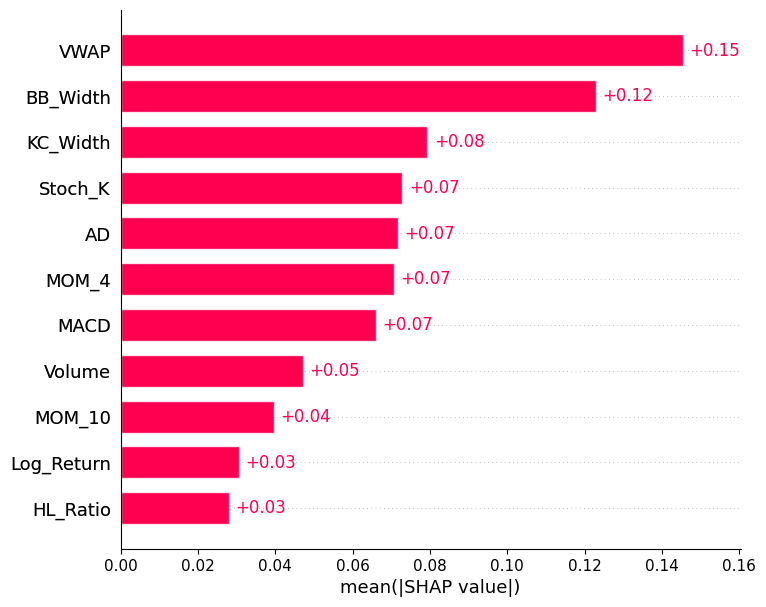

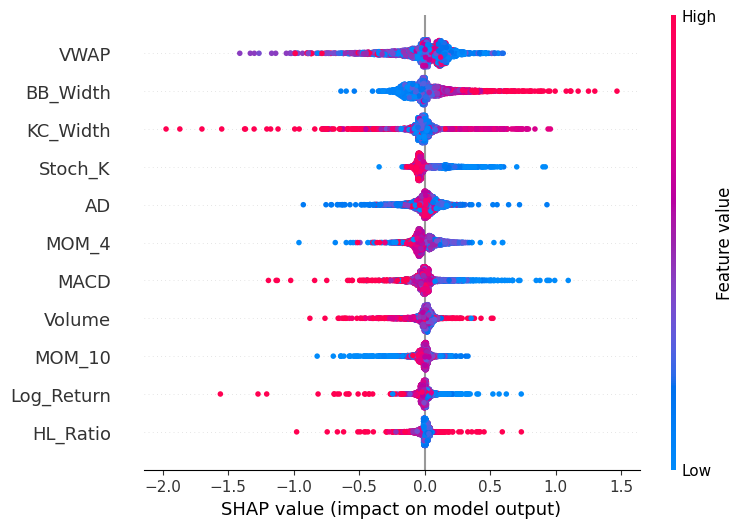

In [29]:
# ===============================
# Gradient boosting model to select features based on shap and importance
# ===============================
model = XGBRegressor(n_estimators=400, max_depth=5, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(train_df[selected_mi_features], train_df['Target'])
explainer = shap.Explainer(model.predict, train_df[selected_mi_features])
shap_values = explainer(train_df[selected_mi_features])

# Compute global importance
shap_importance = shap_values.abs.mean(0)  # mean absolute SHAP values per feature
shap_features = pd.Series(shap_importance.values, index=selected_mi_features).sort_values(ascending=False)
final_features = shap_features.head(12).index.tolist()
print("Final features:", final_features)

# Global importance plot
shap.plots.bar(shap_values, max_display=12)
# Distribution of SHAP values
shap.plots.beeswarm(shap_values, max_display=12)

# Data helpers for the model

In [30]:
# ===============================
# Dropping the columns 
# ===============================
feature_cols = [
    # ── Core price dynamics ─────────────────────────
    'Close',
    'Log_Return',          # primary predictive signal
    'ATR_14',              # volatility regime
    'HL_Ratio',            # intraday range
    'Upper_Shadow',
    'Lower_Shadow',
    
    # ── Momentum / oscillators ──────────────────────
    'RSI_5',               # one RSI only
    'MOM_4',               # momentum over short periods
    'MOM_10',              # momentum over medium periods
    'Stoch_K',             # momentum position
    'MACD',                # trend momentum (keep signal OR macd, not both)

    # ── Trend (derived, not raw) ────────────────────
    'BB_Width',            # BB_HBand - BB_LBand  (create this)
    'KC_Width',            # KC_HBand - KC_LBand  (create this)

    # ── Volume ──────────────────────────────────────
    'Volume',              # raw participation
    'OBV',                 # cumulative pressure
    'Volume_Change',       # (volume pct_change)

    # ── Price structure ─────────────────────────────
    'AD',                  # accumulation/distribution
    'VWAP'                 # institutional anchor
]
selected_cols = feature_cols + ["Target"]
train_df, test_df = df_ta.iloc[:split_idx].copy(), df_ta.iloc[split_idx:].copy()
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]

In [31]:
# ===============================
# Build Sequences 
# ===============================
def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X.iloc[i-seq_len:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

SEQ_LEN = 20  # 4 weeks, HORIZON = 5 here

In [32]:
# ===============================
# Create walk-forward data-split for model training and validation
# ===============================
def walk_forward_splits_n(
    df,
    train_size,
    val_size,
    n_splits,
    embargo
):
    T = len(df)
    max_start = T - (train_size + embargo + val_size)
    if max_start <= 0:
        raise ValueError("Not enough data for the given sizes")

    # evenly spaced starts
    starts = np.linspace(0, max_start, n_splits, dtype=int)

    splits = []
    for start in starts:
        train_end = start + train_size
        val_start = train_end + embargo
        val_end = val_start + val_size
        splits.append((start, train_end, val_start, val_end))

    return splits

splits = walk_forward_splits_n(
    df=train_df,
    train_size=1500,
    val_size=300,
    n_splits=6,
    embargo=max(HORIZON, SEQ_LEN)
)

In [33]:
# ===============================
# Show the splits
# ===============================
for i, (tr0, tr1, v0, v1) in enumerate(splits):
    print( f"Split {i}: Train [{tr0}:{tr1}] ({tr1-tr0}) | Val [{v0}:{v1}] ({v1-v0})")

Split 0: Train [0:1500] (1500) | Val [1520:1820] (300)
Split 1: Train [356:1856] (1500) | Val [1876:2176] (300)
Split 2: Train [712:2212] (1500) | Val [2232:2532] (300)
Split 3: Train [1069:2569] (1500) | Val [2589:2889] (300)
Split 4: Train [1425:2925] (1500) | Val [2945:3245] (300)
Split 5: Train [1782:3282] (1500) | Val [3302:3602] (300)


In [34]:
# ===============================
# Scale the train and val/test dataset
# ===============================
def scale_dfs(tr_df, t_val_df):
    X_scalers = {}
    for col in feature_cols:
        scaler = StandardScaler()
        tr_df[col] = scaler.fit_transform(tr_df[[col]])
        t_val_df[col] = scaler.transform(t_val_df[[col]])
        X_scalers[col] = scaler

    y_scaler = StandardScaler()
    tr_df["Target"] = y_scaler.fit_transform(tr_df[["Target"]])
    t_val_df["Target"]  = y_scaler.transform(t_val_df[["Target"]])

    return tr_df, t_val_df, X_scalers, y_scaler

# Metrics

In [35]:
# ===============================
# Loss metrics for training
# ===============================
def soft_pnl_loss(y_pred, y_true, agr=5.0):
    """
    Differentiable proxy for trading PnL
    k controls aggressiveness (higher = closer to hard threshold)
    """
    pos = torch.tanh(agr * y_pred)
    return -torch.mean(pos * y_true)

def position_penalty(y_pred, lam=1e-3):
    """
    Penalize excessive position sizing / overtrading
    """
    pos = torch.tanh(y_pred)
    return lam * torch.mean(pos ** 2)

In [36]:
# ===============================
# Trading specific metrics 
# ===============================
# Convert predicted returns into trading positions
def trading_signal(y_pred, thr_buy, thr_sell):
    """
    Convert predicted returns into trading positions
    +1 : long
    -1 : short
     0 : flat
    """
    pos = np.zeros_like(y_pred, dtype=np.int8)
    pos[y_pred >  thr_buy] =  1
    pos[y_pred < -thr_sell] = -1
    return pos

# Strategy returns with transaction costs, see if position matches market movement
def strategy_returns(y_true, pos, cost=0.0005):
    """
    y_true : realized log returns
    pos    : trading position at each step
    """
    gross_ret = pos * y_true

    # position changes (turnover)
    trades = np.abs(np.diff(pos, prepend=0))

    net_ret = gross_ret - cost * trades
    return net_ret, trades

# Risk-adjusted return of the strategy: 1 = good risk-adjusted returns, ~0 = neutral, <0 = strategy losing money relative to risk
def sharpe_ratio(returns, periods_per_year):
    mu = np.mean(returns)
    sigma = np.std(returns)
    return 0.0 if sigma < 1e-12 else mu / sigma * np.sqrt(periods_per_year)

# Hit rate (directional accuracy when trading)
def hit_rate(y_true, y_pred, pos):
    """
    Directional accuracy conditional on taking a trade
    """
    mask = pos != 0
    if not np.any(mask):
        return 0.0
    return np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask]))

# Trade rate & turnover: overtrading vs too conservative
def trade_rate(pos):
    return np.mean(pos != 0)

def turnover_rate(trades):
    return np.mean(trades)

# Equity curve & drawdown
def equity_curve(returns):
    return np.cumsum(returns)

def max_drawdown(equity):
    peak = np.maximum.accumulate(equity)
    drawdown = equity - peak
    return np.min(drawdown)

# Balanced score: penalize directional bias, overtrading, keep sharpe as main metric
def balanced_score(returns, pos, trades, periods_per_year, alpha=0.3, beta=0.1):
    """
    alpha : directional imbalance penalty
    beta  : overtrading penalty
    """
    sharpe = sharpe_ratio(returns, periods_per_year)

    buy_rate  = np.mean(pos == 1)
    sell_rate = np.mean(pos == -1)

    imbalance_penalty = abs(buy_rate - sell_rate)
    turnover_penalty  = np.mean(trades)

    return sharpe - alpha * imbalance_penalty - beta * turnover_penalty

# One single evaluation function
def evaluate_strategy(y_true, y_pred, thr_buy, thr_sell, horizon_days, cost=0.0005):
    pos = trading_signal(y_pred, thr_buy, thr_sell)
    ret, trades = strategy_returns(y_true, pos, cost)

    periods_per_year = 252 // horizon_days

    metrics = {
        "sharpe": sharpe_ratio(ret, periods_per_year),
        "hit_rate": hit_rate(y_true, y_pred, pos),
        "trade_rate": trade_rate(pos),
        "turnover": turnover_rate(trades),
        "max_drawdown": max_drawdown(equity_curve(ret)),
        "balanced_score": balanced_score(ret, pos, trades, periods_per_year)
    }
    return metrics, ret, pos

# Create and train the Pytorch model 

In [37]:
# ===============================
# LSTM Regressor 
# ===============================
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, units=64, dropout=0.3, use_layernorm=True):
        super().__init__()
        self.use_layernorm = use_layernorm

        # First LSTM layer (return sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=units, batch_first=True)
        self.ln1 = nn.LayerNorm(units) if use_layernorm else nn.Identity()
        self.drop1 = nn.Dropout(dropout)

        # Second LSTM layer (last output)
        self.lstm2 = nn.LSTM(input_size=units, hidden_size=units//2, batch_first=True)
        self.ln2 = nn.LayerNorm(units//2) if use_layernorm else nn.Identity()
        self.drop2 = nn.Dropout(dropout)

        # Output
        self.fc = nn.Linear(units//2, 1)

        # Initialization like Keras
        for lstm in [self.lstm1, self.lstm2]:
            for name, param in lstm.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, _ = self.lstm1(x)
        out = self.drop1(self.ln1(out))
        out, _ = self.lstm2(out)
        out = self.drop2(self.ln2(out))
        out = out[:, -1, :]  # take last timestep
        out = self.fc(out)
        return out.squeeze(-1)

In [38]:
# ===============================
# Prediction
# ===============================
def predict_loader(model, loader, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            preds.append(model(Xb).cpu().numpy())
            trues.append(yb.numpy())

    return np.concatenate(trues), np.concatenate(preds)

In [39]:
# ===============================
# Train function
# ===============================
def train_model(
    model,
    train_loader,
    val_loader,
    epochs: int = 30,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    alpha: float = 0.1,     # soft PnL loss weight
    agr: float = 5.0,       # soft PnL loss aggressiveness
    beta: float = 1e-3,     # position penalty
    thrs_buy: List[float] = None,
    thrs_sell: List[float] = None,
    horizon_days: int = 1,
    cost: float = 0.0005,
    device: str = "cpu"
):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse_loss_fn = nn.MSELoss()

    history = {"train_loss": [], "val_loss": []}
    for tb, ts in zip(thrs_buy, thrs_sell):
        key = f"{tb}_{ts}"
        history[f"val_sharpe_{key}"] = []
        history[f"val_hit_rate_{key}"] = []
        history[f"val_trade_rate_{key}"] = []
        history[f"val_turnover_{key}"] = []
        history[f"val_max_drawdown_{key}"] = []
        history[f"val_balanced_score_{key}"] = []

    for epoch in range(1, epochs + 1):

        # ── TRAIN ─────────────────────────
        model.train()
        train_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            preds = model(Xb)

            # Ensure shapes are compatible
            preds = preds.view(-1)
            yb = yb.view(-1)

            # Losses
            mse = mse_loss_fn(preds, yb)             # MSE
            pnl = soft_pnl_loss(preds, yb, agr=agr)     # Differentiable PnL proxy
            pos_pen = position_penalty(preds, lam=beta)  # Overtrading control

            # Total loss
            loss = mse + alpha * pnl + pos_pen

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # ── VALIDATION ────────────────────
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb)
                val_loss += mse_loss_fn(preds, yb).item()

            val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)

        # ── TRADING METRICS ─────────────────
        y_true, y_pred = predict_loader(model, val_loader, device)

        for tb, ts in zip(thrs_buy, thrs_sell):
            metrics, _, _ = evaluate_strategy(y_true=y_true, y_pred=y_pred, thr_buy=tb, thr_sell=ts, horizon_days=horizon_days, cost=cost)
            key = f"{tb}_{ts}"
            for k, v in metrics.items():
                history[f"val_{k}_{key}"].append(v)

        # ── LOG ──────────────────────────
        k0 = f"{thrs_buy[0]}_{thrs_sell[0]}"
        print(f"Epoch {epoch:02d} | Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | Sharpe {history[f'val_sharpe_{k0}'][-1]:.2f} | Hit {history[f'val_hit_rate_{k0}'][-1]:.2%} | Trade {history[f'val_trade_rate_{k0}'][-1]:.2%} | Turnover {history[f'val_turnover_{k0}'][-1]:.2%} | MDD {history[f'val_max_drawdown_{k0}'][-1]:.4f} | Balanced {history[f'val_balanced_score_{k0}'][-1]:.4f}")

    return history

# Hyperparameters Tuning 

In [40]:
# ===============================
# Optuna Hyperparameters Tuning 
# ===============================
# should be done for the final model, here we don't really care

In [41]:
# ===============================
# Full model training with walk-forward validation
# ===============================
BATCH_SIZE = 64
THR_BUY = [0.1, 0.25, 0.5, 0.75, 1.0]
THR_SELL = [0.1, 0.25, 0.5, 0.75, 1.0]

alpha = 0.1       # 0.05 – 0.2
beta  = 1e-3      # 1e-4 – 1e-3
agr   = 5.0       # 3 – 10

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_num_threads(1) # extra safety on macOS

all_metrics = []

for i, (tr0, tr1, v0, v1) in enumerate(splits):
    print(f"\n===== Fold {i+1} =====")

    tr_df = train_df.iloc[tr0:tr1].copy()
    val_df = train_df.iloc[v0:v1].copy()

    # scale
    tr_df, val_df, X_scalers, y_scaler = scale_dfs(tr_df, val_df)
    
    # sequences
    Xtr, ytr = make_sequences(tr_df[feature_cols], tr_df["Target"], SEQ_LEN)
    Xva, yva = make_sequences(val_df[feature_cols], val_df["Target"], SEQ_LEN)
    
    train_loader = DataLoader(SequenceDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(SequenceDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False)

    model = LSTMRegressor(n_features=len(feature_cols), units=32, dropout=0.4)

    history = train_model(model, train_loader, val_loader, 
                          epochs=30, lr=1e-3, weight_decay=1e-4, 
                          alpha=alpha, agr=agr, beta=beta, 
                          thrs_buy=THR_BUY, thrs_sell=THR_SELL, 
                          horizon_days=HORIZON, 
                          cost=0.0005, 
                          device=device)
    
    all_metrics.append(history)


===== Fold 1 =====
Epoch 01 | Train MSE 1.3913 | Val MSE 1.0558 | Sharpe -0.33 | Hit 45.65% | Trade 65.71% | Turnover 15.36% | MDD -20.9197 | Balanced -0.5092
Epoch 02 | Train MSE 1.0758 | Val MSE 1.0360 | Sharpe -0.18 | Hit 47.40% | Trade 61.79% | Turnover 13.21% | MDD -22.5897 | Balanced -0.3739
Epoch 03 | Train MSE 1.0435 | Val MSE 1.0519 | Sharpe 0.05 | Hit 46.98% | Trade 76.79% | Turnover 12.50% | MDD -25.2111 | Balanced -0.1903
Epoch 04 | Train MSE 0.9688 | Val MSE 1.0178 | Sharpe 0.13 | Hit 50.97% | Trade 55.36% | Turnover 14.64% | MDD -18.9085 | Balanced -0.0359
Epoch 05 | Train MSE 0.9558 | Val MSE 1.0680 | Sharpe 0.51 | Hit 49.02% | Trade 72.86% | Turnover 9.64% | MDD -26.0841 | Balanced 0.2920
Epoch 06 | Train MSE 0.9000 | Val MSE 1.1241 | Sharpe 0.45 | Hit 47.60% | Trade 74.29% | Turnover 8.93% | MDD -26.9803 | Balanced 0.2342
Epoch 07 | Train MSE 0.8760 | Val MSE 1.0962 | Sharpe 0.48 | Hit 48.24% | Trade 60.71% | Turnover 10.36% | MDD -23.2565 | Balanced 0.3010
Epoch 08 |

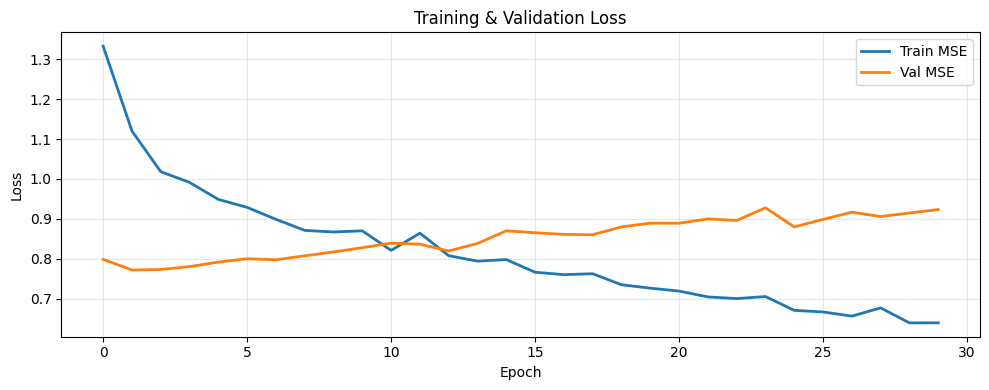

In [42]:
# ===============================
# Plot loss functions
# ===============================
def plot_losses(all_metrics):
    plt.figure(figsize=(10, 4))
    train_loss = np.mean([m["train_loss"] for m in all_metrics], axis=0)
    val_loss = np.mean([m["val_loss"] for m in all_metrics], axis=0)
    plt.plot(train_loss, label="Train MSE", linewidth=2)
    plt.plot(val_loss, label="Val MSE", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_losses(all_metrics)

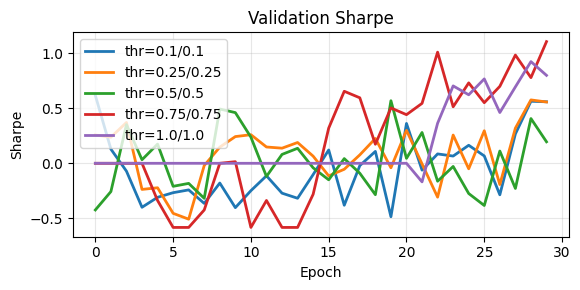

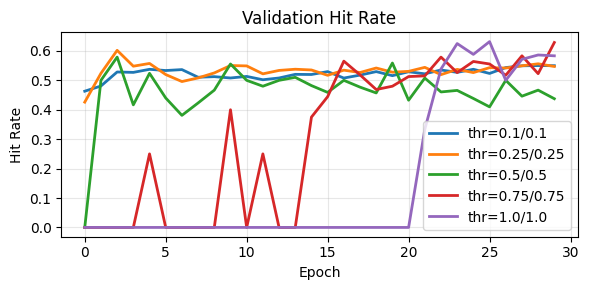

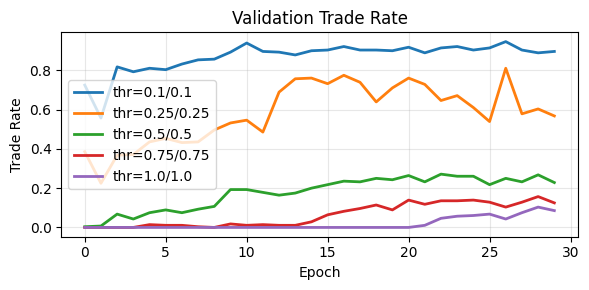

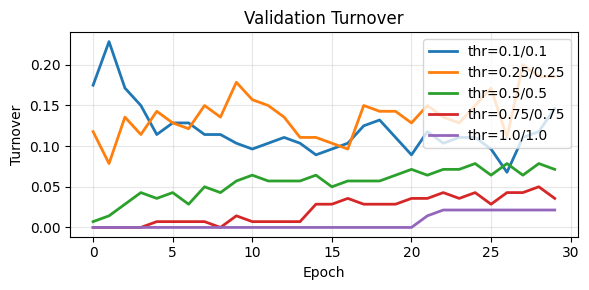

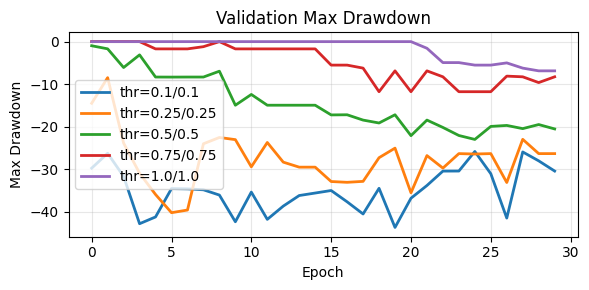

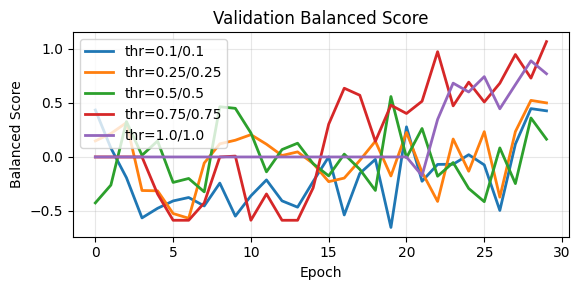

In [43]:
# ===============================
# Plot loss functions
# ===============================
def plot_trading_metric(history, metric_name, thrs_buy, thrs_sell):
    """
    metric_name examples:
    - 'sharpe'
    - 'hit_rate'
    - 'trade_rate'
    - 'turnover'
    - 'max_drawdown'
    - 'balanced_score'
    """
    plt.figure(figsize=(6,3))

    for tb, ts in zip(thrs_buy, thrs_sell):
        key = f"val_{metric_name}_{tb}_{ts}"
        if key not in history:
            raise KeyError(f"Missing {key} in history")
        plt.plot(history[key], label=f"thr={tb}/{ts}", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.title(f"Validation {metric_name.replace('_', ' ').title()}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

TRADING_METRICS = ["sharpe", "hit_rate", "trade_rate", "turnover", "max_drawdown", "balanced_score"]
for m in TRADING_METRICS:
    plot_trading_metric(history, m, THR_BUY, THR_SELL)

# Predictions and Evaluation

In [44]:
# ===============================
# Predictions
# ===============================
train_df, test_df, X_scalers, y_scaler = scale_dfs(train_df, test_df)
Xt, yt = make_sequences(test_df[feature_cols], test_df["Target"], SEQ_LEN)
test_loader = DataLoader(SequenceDataset(Xt, yt), batch_size=BATCH_SIZE, shuffle=False)
y_true, y_pred = predict_loader(model, test_loader, device)

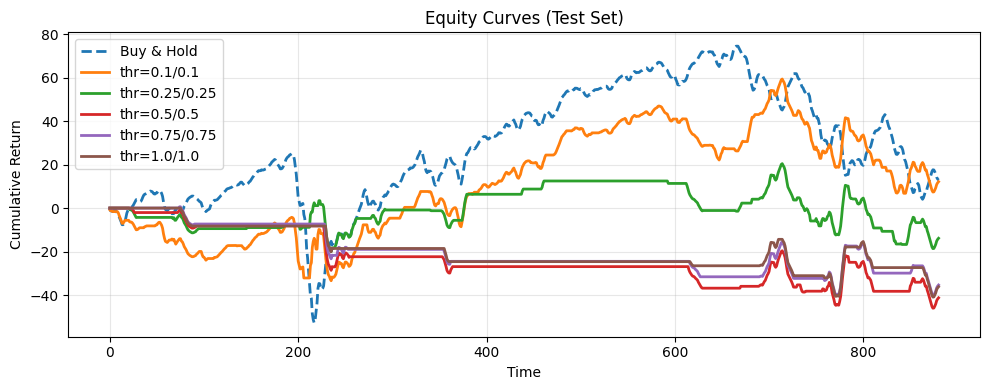

In [45]:
# ===============================
# Equity curves for all thresholds
# ===============================
plt.figure(figsize=(10, 4))

bh_eq = equity_curve(y_true)
plt.plot(bh_eq, "--", label="Buy & Hold", linewidth=2)

for tb, ts in zip(THR_BUY, THR_SELL):
    metrics, ret, pos = evaluate_strategy(y_true=y_true, y_pred=y_pred, thr_buy=tb, thr_sell=ts, horizon_days=HORIZON, cost=0.0005)
    eq = equity_curve(ret)
    plt.plot(eq, label=f"thr={tb}/{ts}", linewidth=2)

plt.title("Equity Curves (Test Set)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# ===============================
# Determine the optimal threshold given our case and some constraints
# ===============================
# we want to penalize under and over trading 
# Volatility-aware threshold optimization
def optimize_thresholds(
    y_true,
    y_pred,
    horizon_days,
    cost=0.0005,
    min_trade_rate=0.02,
    max_trade_rate=0.40,
):
    sigma = np.std(y_pred)

    # multipliers of prediction volatility
    buy_mults  = np.linspace(0.3, 2.0, 15)
    sell_mults = np.linspace(0.3, 2.0, 15)

    best = {"thr_buy": None, "thr_sell": None, "score": -np.inf, "sharpe": None}

    for kb in buy_mults:
        for ks in sell_mults:
            tb =  kb * sigma
            ts =  ks * sigma

            pos = trading_signal(y_pred, tb, ts)
            ret, trades = strategy_returns(y_true, pos, cost)

            trade_r = trade_rate(pos)
            if not (min_trade_rate <= trade_r <= max_trade_rate):
                continue  # reject too flat / too active

            periods_per_year = 252 // horizon_days
            score = balanced_score(ret, pos, trades, periods_per_year)
            if score > best["score"]:
                best.update({"thr_buy": tb, "thr_sell": ts, "score": score, "sharpe": sharpe_ratio(ret, periods_per_year)})

    return best

opt = optimize_thresholds(y_true, y_pred, horizon_days=HORIZON, cost=0.0005)
thr_buy  = opt["thr_buy"]
thr_sell = opt["thr_sell"]
print(f"thr_buy={thr_buy:.5f}, thr_sell={thr_sell:.5f}")

metrics, ret, pos = evaluate_strategy( y_true, y_pred, thr_buy, thr_sell, horizon_days=HORIZON)
print("Buy rate :", np.mean(pos == 1))
print("Sell rate:", np.mean(pos == -1))
print("Neutral  :", np.mean(pos == 0))
print("Sharpe   :", metrics["sharpe"])

thr_buy=0.21674, thr_sell=0.27919
Buy rate : 0.15550510783200908
Sell rate: 0.23609534619750283
Neutral  : 0.6083995459704881
Sharpe   : -0.09426727410113958


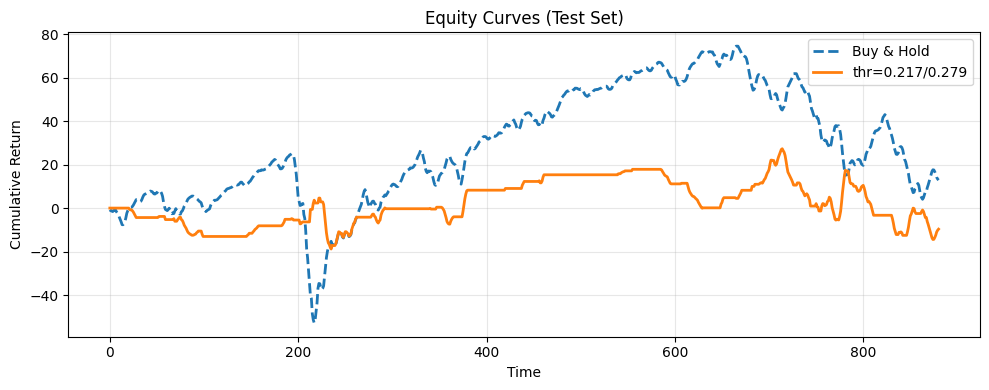

In [58]:
# ===============================
# Equity curves on best threshold
# ===============================
plt.figure(figsize=(10, 4))
bh_eq = equity_curve(y_true)
plt.plot(bh_eq, "--", label="Buy & Hold", linewidth=2)
metrics, ret, pos = evaluate_strategy(y_true=y_true, y_pred=y_pred, thr_buy=thr_buy, thr_sell=thr_sell, horizon_days=HORIZON, cost=0.0005)
eq = equity_curve(ret)
plt.plot(eq, label=f"thr={thr_buy:.3f}/{thr_sell:.3f}", linewidth=2)
plt.title("Equity Curves (Test Set)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [47]:
# ===============================
# Vizualisations
# ===============================

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_73630/1742023437.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_73630/1742023437.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_73630/1742023437.py:38: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




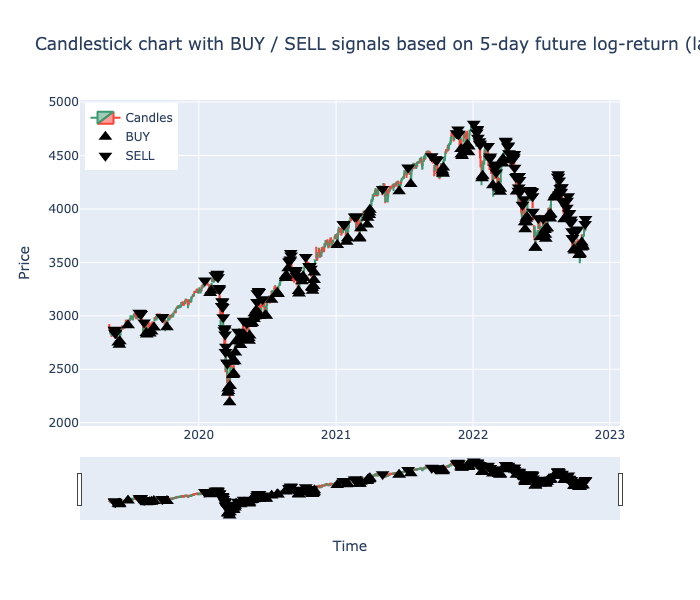

In [48]:
df_slice = df_ta.iloc[split_idx+SEQ_LEN:].copy()
# Identify signals
buy_signals = df_slice[test_df['Target'] > 1]
sell_signals = df_slice[test_df['Target'] < -1]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return (labelling)",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "improved_lstm_full_test_true.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

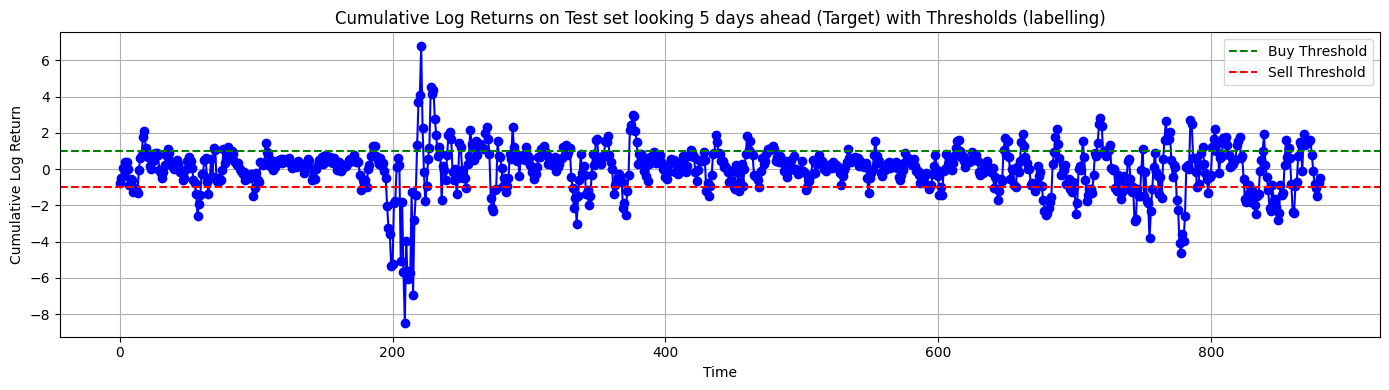

In [49]:
plt.figure(figsize=(14,4))
plt.plot(y_true, marker='o', linestyle='-', color='blue')
plt.axhline(1, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-1, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Cumulative Log Returns on Test set looking {HORIZON} days ahead (Target) with Thresholds (labelling)")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

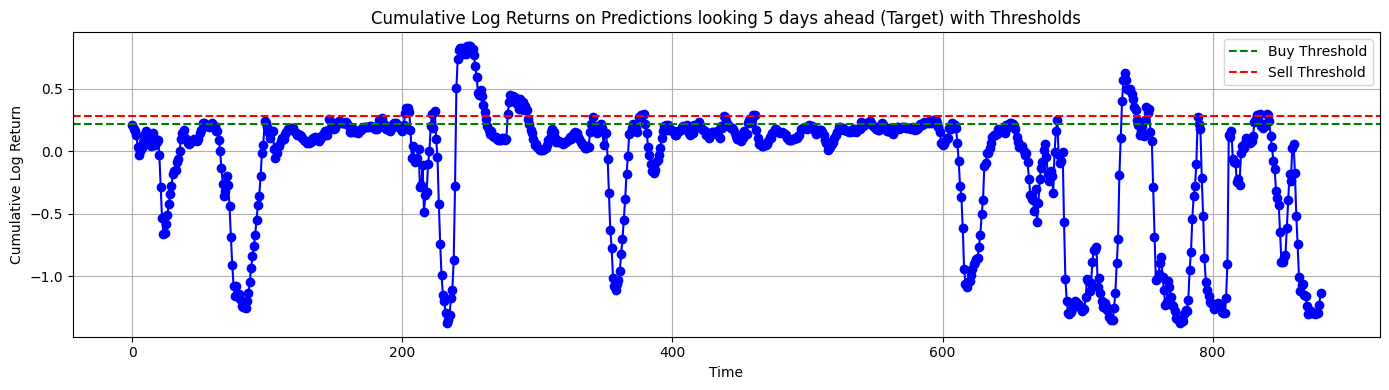

In [59]:
plt.figure(figsize=(14,4))
plt.plot(y_pred, marker='o', linestyle='-', color='blue')
plt.axhline(thr_buy, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(thr_sell, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Cumulative Log Returns on Predictions looking {HORIZON} days ahead (Target) with Thresholds")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_73630/1688344187.py:41: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




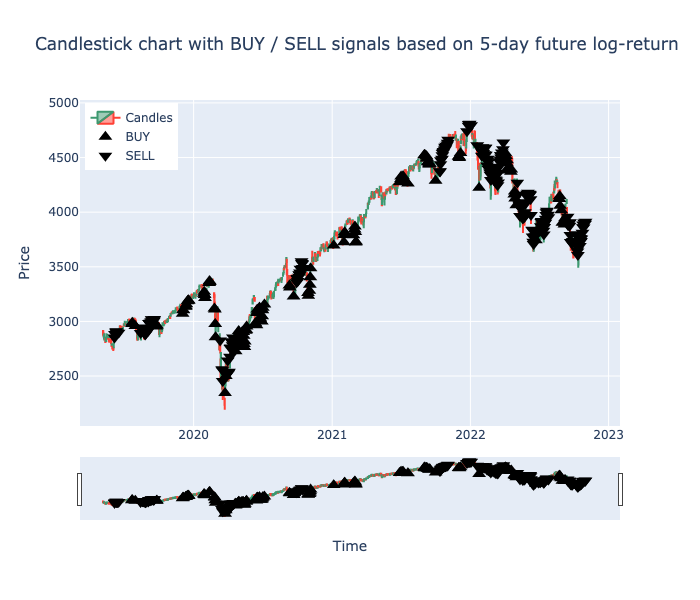

In [60]:
df_slice = df_ta.iloc[split_idx+SEQ_LEN:].copy()
y_pred_slice = y_pred[-len(df_slice):]  # make sure lengths match
df_slice = df_slice.copy()
df_slice["y_pred"] = y_pred_slice
# Identify signals
buy_signals = df_slice[df_slice["y_pred"] > thr_buy]
sell_signals = df_slice[df_slice["y_pred"] < -thr_sell]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "improved_lstm_full_test_pred.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

# Model evaluation using Classification

In [52]:
# ===============================
# Predict action comparing predictions and thresholds
# ===============================
def get_positions(y_true, y_pred, thr_buy=0.0, thr_sell=-0.0):
    # Convert predicted cumulative log return into discrete actions: 0 = neutral, 1 = buy, -2 = sell
    y_pred_label = np.select(
        [y_pred > thr_buy, y_pred < thr_sell],
        [1, -1],  # 1=BUY, -1=SELL, 0=HOLD
        default=0
    )
    y_true_label = np.select(
        [y_true > thr_buy, y_true < thr_sell],
        [1, -1],
        default=0
    )
    return y_true_label, y_pred_label

y_true_label, y_pred_label = get_positions(y_true, y_pred,  thr_buy=thr_buy, thr_sell=-thr_sell)
print("Analytics true:   ", y_true_label[:100])
print("Model predictions:", y_pred_label[:100])

Analytics true:    [-1 -1  0 -1  1  1  0 -1 -1 -1 -1 -1 -1 -1  0  1  1  1  1  1  1  1  0  0
  1  1  1  1  1  0  0 -1  0  1  1  1  1  1  0  1  0  1  1  1  0  0 -1 -1
  0  1  0  1  1  0 -1 -1 -1 -1 -1 -1  0  0  1  1 -1 -1 -1  1 -1  1  1 -1
 -1 -1 -1  0  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0 -1 -1 -1 -1
  0 -1 -1 -1]
Model predictions: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1
 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0 -1 -1  0  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
  0  0  1  1]


In [53]:
# ===============================
# Full predictions classification report
# ===============================
print("----- Classification report -----")
print(classification_report(y_true_label, y_pred_label, digits=4))

summary = {
    "Accuracy"          : accuracy_score(y_true_label, y_pred_label),
    "Balanced accuracy" : balanced_accuracy_score(y_true_label, y_pred_label),
    "Macro-F1"          : f1_score(y_true_label, y_pred_label, average="macro"),
    "Macro-Precision"   : precision_score(y_true_label, y_pred_label, average="macro"),
    "Macro-Recall"      : recall_score(y_true_label, y_pred_label, average="macro"),
    "MCC"               : matthews_corrcoef(y_true_label, y_pred_label)
}
pd.DataFrame(summary, index=["Score"]).T.style.format("{:.4f}")

----- Classification report -----
              precision    recall  f1-score   support

          -1     0.3413    0.2518    0.2898       282
           0     0.2425    0.7345    0.3647       177
           1     0.5182    0.1682    0.2540       422

    accuracy                         0.3087       881
   macro avg     0.3674    0.3848    0.3028       881
weighted avg     0.4062    0.3087    0.2877       881



,Score
Accuracy,0.3087
Balanced accuracy,0.3848
Macro-F1,0.3028
Macro-Precision,0.3674
Macro-Recall,0.3848
MCC,0.0620


----- Confusion Matrix (normalised) -----


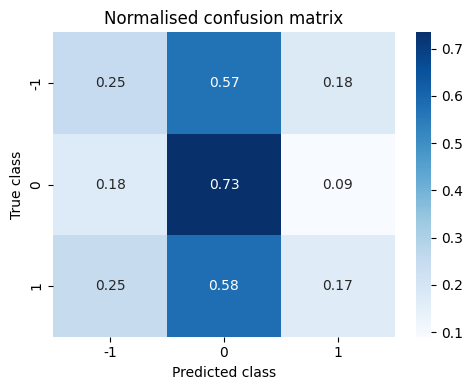

In [55]:
# ===============================
# Confusion-matrix heat-map (normalised row-wise)
# ===============================
print("----- Confusion Matrix (normalised) -----")
cm  = confusion_matrix(y_true_label, y_pred_label, labels=[-1,0,1])
cmn = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", xticklabels=["-1", "0","1"], yticklabels=["-1", "0","1"])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Normalised confusion matrix")
plt.tight_layout()
plt.show()